In [1]:
#!/usr/bin/env python3

In [2]:
import sys, os, json, time, random
#from typing import List, Mapping, Optional
from typing import Mapping, Optional

In [3]:
import itertools

In [4]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=UserWarning)

In [5]:
import numpy as np 
import cv2
import torch

In [6]:
import torch.nn.functional as F

In [7]:
from pathlib import Path

In [8]:
import maskdino
from maskdino.config import add_maskdino_config
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [9]:
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
#from fastai.vision.all import *

In [10]:
from utils.dbgprint import dbgprint
from utils.dbgprint import *

In [11]:
root              = Path('/mnt/raid1/repos/maskdino/')
cfg_dir           = Path('MaskDINO/configs/spread/instance-segmentation/')
output_dir        = 'maskdino-output'
pretrained_models = 'pretrained-models'
img_path          = [
			'images/camvid_old/images/0016E5_08141.png',
			'images/black-car-over-black-background.jpg',
			'images/car-with-complex-background.jpg',
			'images/car-with-white-background.jpg'
		]

In [12]:
cfg_file          = root / cfg_dir / 'spread-maskdino-R50-bs32-3s.yaml'
weight_file       = root / pretrained_models / 'maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth'

In [13]:
dbgprint(config, LogLevel.INFO, f'Loading config  from: {cfg_file}')
dbgprint(config, LogLevel.INFO, f'Loading weights from: {weight_file}')

[22:30:52.414][INFO   ] - [CONFIG    ] Loading config  from: /mnt/raid1/repos/maskdino/MaskDINO/configs/spread/instance-segmentation/spread-maskdino-R50-bs32-3s.yaml
[22:30:52.414][INFO   ] - [CONFIG    ] Loading weights from: /mnt/raid1/repos/maskdino/pretrained-models/maskdino_r50_50ep_300q_hid1024_3sd1_instance_maskenhanced_mask46.1ap_box51.5ap.pth


In [14]:
cfg               = get_cfg()
cfg.set_new_allowed(True)
add_maskdino_config(cfg)
cfg.merge_from_file(str(cfg_file))
cfg.MODEL.WEIGHTS = str(weight_file)
cfg.OUTPUT_DIR    = output_dir

%

In [15]:
dataset_dir = os.getenv("DETECTRON2_DATASETS", "/mnt/raid1/dataset/") # defining the root for the dataset

##### Replacement for Google Colab cv2_imshow

In [16]:
import numpy as np 
import cv2
# comment the original import from google.colab.patch
# from google.colab.patches import cv2_imshow 

# import pytplot from matplotlib if not already imported
import matplotlib.pyplot as plt

# for inline plot rendering
%matplotlib inline

def cv2_imshow(img):
    # set appropriate figure size in case it is too small or too large. Don't worry about it being square.
    plt.figure(figsize=(10,10))
    try:
        # try simple BGR 2 RGB conversion so pyplot can show the image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    except:
        # this is for a special case in case the above doesn't work after applying convolutions
        plt.imshow(cv2.cvtColor(np.uint8(np.absolute(img)), cv2.COLOR_BGR2RGB))
    plt.show(18,10)

# Brutally copy-pasted from train_net.py, I'll understand later...

In [17]:
from detectron2.engine import DefaultTrainer

In [18]:
import logging
from detectron2.utils.logger import setup_logger

In [19]:
import detectron2.utils.comm as comm
import copy

In [20]:
from maskdino import COCOInstanceNewBaselineDatasetMapper

In [21]:
from detectron2.data import MetadataCatalog, build_detection_train_loader
from detectron2.engine import create_ddp_model, AMPTrainer

In [22]:
from detectron2.projects.deeplab import build_lr_scheduler

In [23]:
import weakref

In [24]:
from detectron2.checkpoint import DetectionCheckpointer


<br>
from maskdino import (<br>
    COCOInstanceNewBaselineDatasetMapper,<br>
    COCOPanopticNewBaselineDatasetMapper,<br>
    InstanceSegEvaluator,<br>
    MaskFormerSemanticDatasetMapper,<br>
    SemanticSegmentorWithTTA,<br>
    add_maskdino_config,<br>
    DetrDatasetMapper,<br>
)<br>
from detectron2.engine import (<br>
    DefaultTrainer,<br>
    default_argument_parser,<br>
    default_setup,<br>
    hooks,<br>
    launch,<br>
    create_ddp_model,<br>
    AMPTrainer,<br>
    SimpleTrainer<br>
)<br>


%

In [25]:
catalog = DatasetCatalog
spread_dataset_train = None
for dataset in catalog.list():
    if 'spread' and 'train' in dataset:
        spread_dataset_train = dataset

train_metadata      = MetadataCatalog.get(spread_dataset_train)
train_dataset_dicts = DatasetCatalog.get (spread_dataset_train)

from maskdino.data.dataset_mappers.mask_former_semantic_dataset_mapper import MaskFormerSemanticDatasetMapper
from detectron2.data import build_detection_train_loader
from detectron2.engine.train_loop import SimpleTrainer
from detectron2.modeling import build_model
from detectron2.solver import build_optimizer
import logging
from detectron2.utils.events import EventStorage, get_event_storage
from tqdm import tqdm
import wandb
import weakref

In [26]:
from detectron2.checkpoint import DetectionCheckpointer

In [27]:
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.modeling.postprocessing import sem_seg_postprocess

In [28]:
from format import Text

In [29]:
class MyTrainer(SimpleTrainer):
    def __init__(self, cfg, log=True, zero_grad_before_forward=False):
        
        model = build_model(cfg)
        mapper = MaskFormerSemanticDatasetMapper(cfg)
        data_loader = build_detection_train_loader(cfg, mapper=mapper)
        optimizer = build_optimizer(cfg, model)
        super().__init__(model, data_loader, optimizer, zero_grad_before_forward=False)
        
        self.log = log
        self.classes = self.get_classes_dict(cfg)
        self.checkpointer = DetectionCheckpointer(
            self.model,
            cfg.OUTPUT_DIR,
            trainer=weakref.proxy(self)
        )
        
        if cfg.MODEL.WEIGHTS is None:
            self.checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=False)
    
    def get_classes_dict(self, cfg):
        metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
        classes = metadata.get('stuff_classes')
        return {k: cls for k, cls in enumerate(classes)}
    def run_step(self):
        """
        Implement the standard training logic described above.
        """
        assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        start = time.perf_counter()
        """
        If you want to do something with the data, you can wrap the dataloader.
        """
        data = next(self._data_loader_iter)
        data_time = time.perf_counter() - start
        if self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
        """
        If you want to do something with the losses, you can wrap the model.
        """
        loss_dict, outputs = self.model(data)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        if not self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
    
        if self.log:
            wandb.log({'loss': losses, 'iter': self.iter})
            if self.iter % 100 == 0: #Introduce variable in cfg for images to save 
                self.save_images(data, outputs)
        
        losses.backward()
        self.after_backward()
        if self.async_write_metrics:
            # write metrics asynchronically
            self.concurrent_executor.submit(
                self._write_metrics, loss_dict, data_time, iter=self.iter
            )
        else:
            self._write_metrics(loss_dict, data_time)
        """
        If you need gradient clipping/scaling or other processing, you can
        wrap the optimizer with your custom `step()` method. But it is
        suboptimal as explained in https://arxiv.org/abs/2006.15704 Sec 3.2.4
        """
        self.optimizer.step()
    
    def train(self, start_iter: int = 0, max_iter: int = cfg.SOLVER.MAX_ITER):
        super().train(start_iter, max_iter)
    def before_train(self):
        super().before_train()
        if self.log:
            wandb.init(project='maskdino', config=cfg)
    def after_train(self):
        super().after_train()
        self.checkpointer.save(name=cfg.SAVED_MODEL_NAME)
        if self.log:
            wandb.finish()
    def save_images(self, batched_input: list[dict], outputs: dict) -> None:
        i = random.randint(0, len(batched_input)-1)
        image_dict = batched_input[i]
        image, mask_gt = image_dict['image'], image_dict['sem_seg']
        mask, logits = outputs['pred_masks'][i], outputs['pred_logits'][i]
        mask_cls = F.softmax(logits, dim=-1)[..., :-1]
        mask = mask.sigmoid()
        semseg = torch.einsum("qc,qhw->chw", mask_cls, mask)
        semseg = F.interpolate(semseg.view(1,semseg.shape[0],semseg.shape[1],semseg.shape[2]),
                            size=(image.shape[1], image.shape[2])).detach()
        
        mask_pred = np.argmax(semseg.cpu(), axis=1)
        masked_img = wandb.Image(image, masks={'prediction': {'mask_data': mask_pred[0].numpy(), 'class_labels': self.classes},
                                            'ground_truth': {'mask_data': mask_gt.numpy(), 'class_labels': self.classes}})
        wandb.log({'masked_image': masked_img})

%


<br>
Inspect the functions/variables (model -> MaskDINO class):<br>
    model.sem_seg_postprocess_before_inference<br>
    sem_seg_postprocess ('ndo sta???)<br>
    model.semantic_inference<br>
    model.semantic_on (deal with instance_on and panoptic_on)<br>



<br>
model = build_model(cfg)<br>
mapper = MaskFormerSemanticDatasetMapper(cfg)<br>
data_loader = build_detection_train_loader(cfg, mapper=mapper)<br>
optimizer = build_optimizer(cfg, model)<br>


the output directory can be set in 

In [30]:
dbgprint(config, LogLevel.INFO, f'Output dir is: {cfg.OUTPUT_DIR}')

[22:31:07.591][INFO   ] - [CONFIG    ] Output dir is: maskdino-output


ddind a cfg key for the name of the model to save

In [31]:
cfg.SAVED_MODEL_NAME = "maskdino-spread-instance-segmentation"


<br>
new_trainer = MyTrainer(cfg, log=True, zero_grad_before_forward=True)<br>
new_trainer.train()<br>
from detectron2.evaluation.sem_seg_evaluation import SemSegEvaluator<br>
cfg.MODEL.WEIGHTS = os.path.join(root,<br>
                                 output_dir,<br>
                                 'maskdino_fine_tuned.pth')<br>
model = build_model(cfg)<br>
evaluator = SemSegEvaluator(cfg.DATASETS.TEST[0], cfg.OUTPUT_DIR)<br>
#the path of the images are in:<br>
print(f'{Text(evaluator.input_file_to_gt_file, 'evaluator.input_file_to_gt_file'):inspect}')<br>
# %%<br>


rom train_net import Trainer

rainer = DefaultTrainer(cfg)

In [32]:
from detectron2.utils.visualizer import Visualizer

def draw_instance_predictions(img, outputs, metadata, bgr=False):
    # outputs.keys() = dict_keys(['pred_logits', 'pred_masks', 'pred_boxes', 'aux_outputs', 'interm_outputs'])
    dbgprint(train, LogLevel.INFO,  f'{outputs.keys() = }')
    #img = outputs['image']
    instances = outputs['instances']
    if isinstance(img, torch.Tensor):
        img = img.permute(1,2,0).detach().cpu().numpy()
    if bgr:
        img = img[:, :, ::-1]
    dbgprint(train, LogLevel.INFO,  f'{image.shape = } - {image.dtype = } - {image[image!=0][:50]}')
    dbgprint(train, LogLevel.TRACE, f'{instances._fields = }')
    for k, v in instances._fields.items():
        dbgprint(train, LogLevel.INFO, f'{k = } - {len(v)} items')
    '''
    for idx in range(len(instances)):
        inst = instances[idx]
        dbgprint(train, LogLevel.INFO, f'{type(inst) = }')
        dbgprint(train, LogLevel.INFO, f'{inst.shape = } - {inst.dtype = } - {inst[inst!=0][:50]}')
    '''
    # We can use `Visualizer` to draw the predictions on the image.
    #visualizer = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.8)
    #out = visualizer.draw_instance_predictions(instances.to("cpu"))
    #out = visualizer.draw_dataset_dict(instances)
    #cv2_imshow(out.get_image()[:, :, ::-1])
    
    visualizer = Visualizer(img, metadata=metadata, scale=1.0,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out_vis    = visualizer.draw_instance_predictions(instances.to("cpu"))
    out_img    = out_vis.get_image()[:, :, ::-1]
    cv2_imshow(out_img)
    return out_img

In [33]:
class CustomInstanceSegmentationTrainer(DefaultTrainer):
    """
    Extension of the Trainer class adapted to MaskFormer.
    """
    def __init__(self, cfg, wandb_log=False,
                 zero_grad_before_forward=False, async_write_metrics=False,
                 auto_scale_workers=False, gather_metric_period=1):
        '''
            Args:
            gather_metric_period: an int. Every gather_metric_period iterations
                the metrics are gathered from all the ranks to rank 0 and logged.
            zero_grad_before_forward: whether to zero the gradients before the forward.
            async_write_metrics: bool. If True, then write metrics asynchronously to improve
                training speed
        '''
        super(DefaultTrainer, self).__init__()
        #super().__init__(model, data_loader, optimizer, zero_grad_before_forward=False)
        
        self.wandb = wandb_log
        self.zero_grad_before_forward = zero_grad_before_forward
        self.async_write_metrics = async_write_metrics
        self.auto_scale_workers = auto_scale_workers
        # create a thread pool that can execute non critical logic in run_step asynchronically
        # use only 1 worker so tasks will be executred in order of submitting.
        #self.concurrent_executor = concurrent.futures.ThreadPoolExecutor(max_workers=1)
        self.gather_metric_period = gather_metric_period
        logger = logging.getLogger("MaskDINO")
        if not logger.isEnabledFor(logging.INFO):  # setup_logger is not called for d2
            setup_logger()
        dbgprint(train, LogLevel.INFO, f'comm.get_world_size() is {comm.get_world_size()}')
        
        if self.auto_scale_workers:
            # https://github.com/facebookresearch/detectron2/blob/main/detectron2/engine/defaults.py
            cfg = DefaultTrainer.auto_scale_workers(cfg, comm.get_world_size())

        # Assume these objects must be constructed in this order.
        model = self.build_model(cfg)
        optimizer = self.build_optimizer(cfg, model)
        data_loader = self.build_train_loader(cfg)
        model = create_ddp_model(model, broadcast_buffers=False)
        if cfg.SOLVER.AMP.ENABLED:
            dbgprint(train, LogLevel.INFO, f'SOLVER.AMP.ENABLED is True, creating an AMPTrainer')
            self._trainer = AMPTrainer(model, data_loader, optimizer)
        else:
            dbgprint(train, LogLevel.INFO, f'SOLVER.AMP.ENABLED is False, creating a SimpleTrainer')
            self._trainer = SimpleTrainer(model, data_loader, optimizer)
        '''
        self._trainer = (AMPTrainer if cfg.SOLVER.AMP.ENABLED else SimpleTrainer)(
            model, data_loader, optimizer
        )
        '''
        self.scheduler = self.build_lr_scheduler(cfg, optimizer)

        # add model EMA
        kwargs = {
            'trainer': weakref.proxy(self),
        }
        # kwargs.update(model_ema.may_get_ema_checkpointer(cfg, model)) TODO: release ema training for large models
        self.checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR,
            **kwargs,
        )
        self.start_iter = 0
        self.max_iter = cfg.SOLVER.MAX_ITER
        self.cfg = cfg
        self.register_hooks(self.build_hooks())
        # TODO: release model conversion checkpointer from DINO to MaskDINO
        self.checkpointer = DetectionCheckpointer(
            # Assume you want to save checkpoints together with logs/statistics
            model,
            cfg.OUTPUT_DIR,
            **kwargs,
        )
        # TODO: release GPU cluster submit scripts based on submitit for multi-node training
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        Create evaluator(s) for a given dataset.
        This uses the special metadata "evaluator_type" associated with each
        builtin dataset. For your own dataset, you can simply create an
        evaluator manually in your script and do not have to worry about the
        hacky if-else logic here.
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        evaluator_list = []
        evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
        # semantic segmentation
        if evaluator_type in ["sem_seg", "ade20k_panoptic_seg"]:
            evaluator_list.append(
                SemSegEvaluator(
                    dataset_name,
                    distributed=True,
                    output_dir=output_folder,
                )
            )
        # instance segmentation
        if evaluator_type == "coco":
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        # panoptic segmentation
        if evaluator_type in [
            "coco_panoptic_seg",
            "ade20k_panoptic_seg",
            "cityscapes_panoptic_seg",
            "mapillary_vistas_panoptic_seg",
        ]:
            if cfg.MODEL.MaskDINO.TEST.PANOPTIC_ON:
                evaluator_list.append(COCOPanopticEvaluator(dataset_name, output_folder))
        # COCO
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
            evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "coco_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Mapillary Vistas
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        if evaluator_type == "mapillary_vistas_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.SEMANTIC_ON:
            evaluator_list.append(SemSegEvaluator(dataset_name, distributed=True, output_dir=output_folder))
        # Cityscapes
        if evaluator_type == "cityscapes_instance":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesInstanceEvaluator(dataset_name)
        if evaluator_type == "cityscapes_sem_seg":
            assert (
                torch.cuda.device_count() > comm.get_rank()
            ), "CityscapesEvaluator currently do not work with multiple machines."
            return CityscapesSemSegEvaluator(dataset_name)
        if evaluator_type == "cityscapes_panoptic_seg":
            if cfg.MODEL.MaskDINO.TEST.SEMANTIC_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesSemSegEvaluator(dataset_name))
            if cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
                assert (
                    torch.cuda.device_count() > comm.get_rank()
                ), "CityscapesEvaluator currently do not work with multiple machines."
                evaluator_list.append(CityscapesInstanceEvaluator(dataset_name))
        # ADE20K
        if evaluator_type == "ade20k_panoptic_seg" and cfg.MODEL.MaskDINO.TEST.INSTANCE_ON:
            evaluator_list.append(InstanceSegEvaluator(dataset_name, output_dir=output_folder))
        # LVIS
        if evaluator_type == "lvis":
            return LVISEvaluator(dataset_name, output_dir=output_folder)
        if len(evaluator_list) == 0:
            raise NotImplementedError(
                "no Evaluator for the dataset {} with the type {}".format(
                    dataset_name, evaluator_type
                )
            )
        elif len(evaluator_list) == 1:
            return evaluator_list[0]
        return DatasetEvaluators(evaluator_list)
    @classmethod
    def build_train_loader(cls, cfg):
        # coco instance segmentation lsj new baseline
        if cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_lsj":
            mapper = COCOInstanceNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco instance segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_instance_detr":
            mapper = DetrDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # coco panoptic segmentation lsj new baseline
        elif cfg.INPUT.DATASET_MAPPER_NAME == "coco_panoptic_lsj":
            mapper = COCOPanopticNewBaselineDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        # Semantic segmentation dataset mapper
        elif cfg.INPUT.DATASET_MAPPER_NAME == "mask_former_semantic":
            mapper = MaskFormerSemanticDatasetMapper(cfg, True)
            return build_detection_train_loader(cfg, mapper=mapper)
        else:
            mapper = None
            return build_detection_train_loader(cfg, mapper=mapper)
    @classmethod
    def build_lr_scheduler(cls, cfg, optimizer):
        """
        It now calls :func:`detectron2.solver.build_lr_scheduler`.
        Overwrite it if you'd like a different scheduler.
        """
        return build_lr_scheduler(cfg, optimizer)
    @classmethod
    def build_optimizer(cls, cfg, model):
        weight_decay_norm = cfg.SOLVER.WEIGHT_DECAY_NORM
        weight_decay_embed = cfg.SOLVER.WEIGHT_DECAY_EMBED
        defaults = {}
        defaults["lr"] = cfg.SOLVER.BASE_LR
        defaults["weight_decay"] = cfg.SOLVER.WEIGHT_DECAY
        norm_module_types = (
            torch.nn.BatchNorm1d,
            torch.nn.BatchNorm2d,
            torch.nn.BatchNorm3d,
            torch.nn.SyncBatchNorm,
            # NaiveSyncBatchNorm inherits from BatchNorm2d
            torch.nn.GroupNorm,
            torch.nn.InstanceNorm1d,
            torch.nn.InstanceNorm2d,
            torch.nn.InstanceNorm3d,
            torch.nn.LayerNorm,
            torch.nn.LocalResponseNorm,
        )
        params: List[Dict[str, Any]] = []
        memo: Set[torch.nn.parameter.Parameter] = set()
        for module_name, module in model.named_modules():
            for module_param_name, value in module.named_parameters(recurse=False):
                if not value.requires_grad:
                    continue
                # Avoid duplicating parameters
                if value in memo:
                    continue
                memo.add(value)
                hyperparams = copy.copy(defaults)
                if "backbone" in module_name:
                    hyperparams["lr"] = hyperparams["lr"] * cfg.SOLVER.BACKBONE_MULTIPLIER
                if (
                    "relative_position_bias_table" in module_param_name
                    or "absolute_pos_embed" in module_param_name
                ):
                    dbgprint(network, LogLevel.INFO, f'{module_param_name = }')
                    hyperparams["weight_decay"] = 0.0
                if isinstance(module, norm_module_types):
                    hyperparams["weight_decay"] = weight_decay_norm
                if isinstance(module, torch.nn.Embedding):
                    hyperparams["weight_decay"] = weight_decay_embed
                params.append({"params": [value], **hyperparams})
        def maybe_add_full_model_gradient_clipping(optim):
            # detectron2 doesn't have full model gradient clipping now
            clip_norm_val = cfg.SOLVER.CLIP_GRADIENTS.CLIP_VALUE
            enable = (
                cfg.SOLVER.CLIP_GRADIENTS.ENABLED
                and cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model"
                and clip_norm_val > 0.0
            )
            class FullModelGradientClippingOptimizer(optim):
                def step(self, closure=None):
                    all_params = itertools.chain(*[x["params"] for x in self.param_groups])
                    torch.nn.utils.clip_grad_norm_(all_params, clip_norm_val)
                    super().step(closure=closure)
            return FullModelGradientClippingOptimizer if enable else optim
        optimizer_type = cfg.SOLVER.OPTIMIZER
        if optimizer_type == "SGD":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.SGD)(
                params, cfg.SOLVER.BASE_LR, momentum=cfg.SOLVER.MOMENTUM
            )
        elif optimizer_type == "ADAMW":
            optimizer = maybe_add_full_model_gradient_clipping(torch.optim.AdamW)(
                params, cfg.SOLVER.BASE_LR
            )
        else:
            raise NotImplementedError(f"no optimizer type {optimizer_type}")
        if not cfg.SOLVER.CLIP_GRADIENTS.CLIP_TYPE == "full_model":
            optimizer = maybe_add_gradient_clipping(cfg, optimizer)
        return optimizer
    @classmethod
    def test_with_TTA(cls, cfg, model):
        logger = logging.getLogger("detectron2.trainer")
        # In the end of training, run an evaluation with TTA.
        logger.info("Running inference with test-time augmentation ...")
        model = SemanticSegmentorWithTTA(cfg, model)
        evaluators = [
            cls.build_evaluator(
                cfg, name, output_folder=os.path.join(cfg.OUTPUT_DIR, "inference_TTA")
            )
            for name in cfg.DATASETS.TEST
        ]
        res = cls.test(cfg, model, evaluators)
        res = OrderedDict({k + "_TTA": v for k, v in res.items()})
        return res
    def train(self, start_iter: int = 0, max_iter: int = cfg.SOLVER.MAX_ITER):
        dbgprint(main  , LogLevel.INFO, f'Starting training...')
        super().train()
        #super().train(start_iter, max_iter)
    def before_train(self):
        dbgprint(config, LogLevel.INFO, f'Learning rate	: {cfg.SOLVER.BASE_LR}')
        dbgprint(config, LogLevel.INFO, f'Batch size	: {cfg.SOLVER.IMS_PER_BATCH}')
        dbgprint(config, LogLevel.INFO, f'Num steps	: {cfg.SOLVER.MAX_ITER}')
        dbgprint(config, LogLevel.INFO, f'Num workers	: {cfg.DATALOADER.NUM_WORKERS}')
        dbgprint(config, LogLevel.INFO, f'Ckpt every	: {cfg.SOLVER.CHECKPOINT_PERIOD}')
        super().before_train()
        if self.wandb:
            wandb.init(project='maskdino-spread-instance-segmentation', config=cfg)
    def after_train(self):
        super().after_train()
        self.checkpointer.save(name=cfg.SAVED_MODEL_NAME)
        if self.wandb:
            wandb.finish()
    def save_images(self, batched_input: list[dict], outputs: dict) -> None:
        i = random.randint(0, len(batched_input)-1)
        image_dict = batched_input[i]
        dbgprint(train, LogLevel.INFO, f'{image_dict.keys() = }')
        dbgprint(train, LogLevel.INFO, f'{type(image_dict["instances"]) = } - {len(image_dict["instances"]) = }')
        image, mask_gt = image_dict['image'], image_dict['instances'][0]
        dbgprint(train, LogLevel.INFO, f'{type(mask_gt) = } - {len(mask_gt) = }')
        #for idx in range(len(mask_gt)): #._fields.items():
        #    dbgprint(train, LogLevel.INFO, f'{type(mask_gt[idx]) = }')
        dbgprint(train, LogLevel.INFO, f'{image.shape = } - {image.dtype = } - {image[image!=0][:50]}')
        #dbgprint(train, LogLevel.INFO, f'{mask_gt.shape = } - {mask_gt.dtype = } - {mask_gt[mask_gt!=0][:50]}')
        cv2_imshow(image)
        cv2_imshow(mask_gt)
        dbgprint(train, LogLevel.INFO, f'{outputs.keys() = }')
        mask, logits = outputs['pred_masks'][i], outputs['pred_logits'][i]
        mask_cls = F.softmax(logits, dim=-1)[..., :-1]
        mask = mask.sigmoid()
        semseg = torch.einsum("qc,qhw->chw", mask_cls, mask)
        semseg = F.interpolate(semseg.view(1,semseg.shape[0],semseg.shape[1],semseg.shape[2]),
                            size=(image.shape[1], image.shape[2])).detach()
        
        mask_pred = np.argmax(semseg.cpu(), axis=1)
        masked_img = wandb.Image(image, masks={'prediction': {'mask_data': mask_pred[0].numpy(), 'class_labels': self.classes},
                                            'ground_truth': {'mask_data': mask_gt.numpy(), 'class_labels': self.classes}})
        wandb.log({'masked_image': masked_img})
    def run_step(self):
        """
        Implement the standard training logic described above.
        """
        #assert self.model.training, "[SimpleTrainer] model was changed to eval mode!"
        if not self.model.training:
            #, "[SimpleTrainer] model was changed to eval mode!"
            #self.model.train()
            dbgprint(train, LogLevel.ERROR, "Model is in eval mode!")
        start = time.perf_counter()
        """
        If you want to do something with the data, you can wrap the dataloader.
        """
        #data = next(self._data_loader_iter)
        data = next(self.data_loader.__iter__())
        data_time = time.perf_counter() - start
        if self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
        """
        If you want to do something with the losses, you can wrap the model.
        """
        loss_dict, outputs = self.model(data)
        if isinstance(loss_dict, torch.Tensor):
            losses = loss_dict
            loss_dict = {"total_loss": loss_dict}
        else:
            losses = sum(loss_dict.values())
        if not self.zero_grad_before_forward:
            """
            If you need to accumulate gradients or do something similar, you can
            wrap the optimizer with your custom `zero_grad()` method.
            """
            self.optimizer.zero_grad()
    
        if self.wandb:
            draw_instance_predictions(outputs, train_metadata, bgr=False)
            wandb.log({'loss': losses, 'iter': self.iter})
            if self.iter % 100 == 0: #Introduce variable in cfg for images to save 
                self.save_images(data, outputs)
        
        losses.backward()
        self.after_backward()
        if self.async_write_metrics:
            # write metrics asynchronically
            self.concurrent_executor.submit(
                self._write_metrics, loss_dict, data_time, iter=self.iter
            )
        else:
            self._write_metrics(loss_dict, data_time)
        """
        If you need gradient clipping/scaling or other processing, you can
        wrap the optimizer with your custom `step()` method. But it is
        suboptimal as explained in https://arxiv.org/abs/2006.15704 Sec 3.2.4
        """
        self.optimizer.step()
    def _write_metrics(
        self,
        loss_dict: Mapping[str, torch.Tensor],
        data_time: float,
        prefix: str = "",
        iter: Optional[int] = None,
    ) -> None:
        logger = logging.getLogger(__name__)
        iter = self.iter if iter is None else iter
        if (iter + 1) % self.gather_metric_period == 0:
            try:
                SimpleTrainer.write_metrics(loss_dict, data_time, iter, prefix)
            except Exception:
                logger.exception("Exception in writing metrics: ")
                raise
    @staticmethod
    def write_metrics(
        loss_dict: Mapping[str, torch.Tensor],
        data_time: float,
        cur_iter: int,
        prefix: str = "",
    ) -> None:
        """
        Args:
            loss_dict (dict): dict of scalar losses
            data_time (float): time taken by the dataloader iteration
            prefix (str): prefix for logging keys
        """
        metrics_dict = {k: v.detach().cpu().item() for k, v in loss_dict.items()}
        metrics_dict["data_time"] = data_time
        storage = get_event_storage()
        # Keep track of data time per rank
        storage.put_scalar("rank_data_time", data_time, cur_iter=cur_iter)

        # Gather metrics among all workers for logging
        # This assumes we do DDP-style training, which is currently the only
        # supported method in detectron2.
        all_metrics_dict = comm.gather(metrics_dict)
        if comm.is_main_process():
            # data_time among workers can have high variance. The actual latency
            # caused by data_time is the maximum among workers.
            data_time = np.max([x.pop("data_time") for x in all_metrics_dict])
            storage.put_scalar("data_time", data_time, cur_iter=cur_iter)

            # average the rest metrics
            metrics_dict = {
                k: np.mean([x[k] for x in all_metrics_dict]) for k in all_metrics_dict[0].keys()
            }
            total_losses_reduced = sum(metrics_dict.values())
            if not np.isfinite(total_losses_reduced):
                raise FloatingPointError(
                    f"Loss became infinite or NaN at iteration={cur_iter}!\n"
                    f"loss_dict = {metrics_dict}"
                )
            storage.put_scalar(
                "{}total_loss".format(prefix), total_losses_reduced, cur_iter=cur_iter
            )
            if len(metrics_dict) > 1:
                storage.put_scalars(cur_iter=cur_iter, **metrics_dict)

In [34]:
trainer = CustomInstanceSegmentationTrainer(cfg, wandb_log=False)
trainer.resume_or_load(resume=False)
batch_tr = next(trainer.data_loader.__iter__())
for e in batch_tr:
    dbgprint(dataloader, LogLevel.TRACE, f'{type(e) = }')
    if isinstance(e, dict):
        for i, key in enumerate(e.keys()):
            if i == 0:
                dbgprint(dataloader, LogLevel.TRACE, f'\t{key} = {e[key]}')
            else:
                dbgprint(dataloader, LogLevel.TRACE, f'\t{key}')
#trainer.train()

[22:31:07.705][INFO   ] - [TRAIN     ] comm.get_world_size() is 1
criterion.weight_dict  {'loss_ce': 4.0, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 4.0, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 4.0, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 4.0, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 4.0, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 4.0, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 4.0, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 4.0, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_bbox_interm_dn_0': 5

Skip loading parameter 'sem_seg_head.predictor.class_embed.weight' to the model due to incompatible shapes: (80, 256) in the checkpoint but (1, 256) in the model! You might want to double check if this is expected.
Skip loading parameter 'sem_seg_head.predictor.class_embed.bias' to the model due to incompatible shapes: (80,) in the checkpoint but (1,) in the model! You might want to double check if this is expected.
Skip loading parameter 'sem_seg_head.predictor.label_enc.weight' to the model due to incompatible shapes: (80, 256) in the checkpoint but (1, 256) in the model! You might want to double check if this is expected.
Skip loading parameter 'criterion.empty_weight' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
criterion.empty_weight
sem_seg_head.predictor.class_embed.{bias, weight}
sem_seg_head.predictor.label_enc.weight


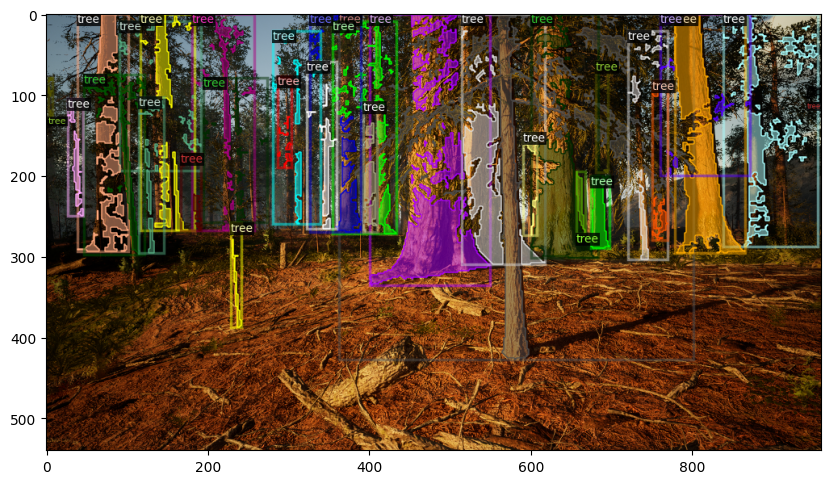

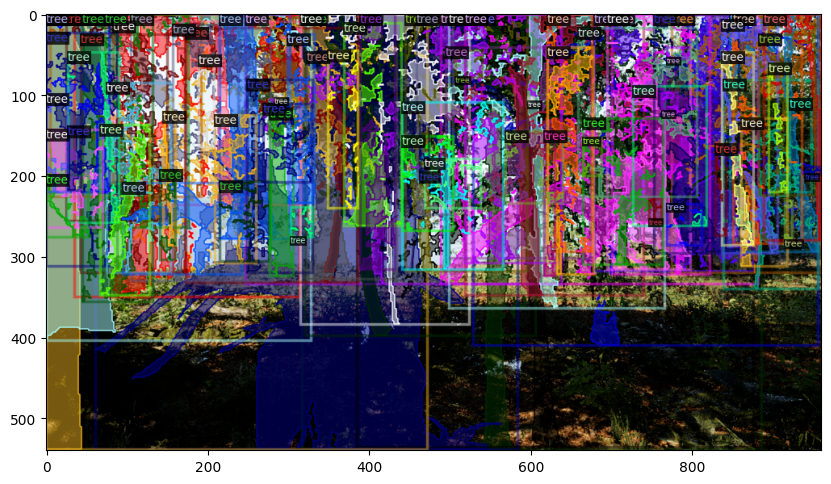

In [35]:
def show_one_batch(train_metadata, train_dataset_dicts, bgr=False):
    # Visualize some random samples
    # train_metadata      = MetadataCatalog.get("spread_train")
    # train_dataset_dicts = DatasetCatalog.get ("spread_train")
    for d in random.sample(train_dataset_dicts, 2):
        img = cv2.imread(d["file_name"])
        if bgr:
            img = img[:, :, ::-1]
        visualizer = Visualizer(img, metadata=train_metadata, scale=1)
        vis_img    = visualizer.draw_dataset_dict(d)
        out_img    = vis_img.get_image()[:, :, ::-1]
        dbgprint(train, LogLevel.TRACE, f'{out_img.shape = } - {out_img.dtype = } - {out_img[out_img!=0][:50]}')
        #plt.imshow(out_img)
        #plt.show(36,20)
        cv2_imshow(out_img)

show_one_batch(train_metadata, train_dataset_dicts, bgr=True)

In [36]:
def show_one_batch2():
    one_batch = next(trainer.data_loader.__iter__())
    idx = random.randint(0, len(one_batch)-1)
    image_dict = one_batch[idx]
    dbgprint(train, LogLevel.INFO, f'{image_dict.keys() = }')
    dbgprint(train, LogLevel.INFO, f'{type(image_dict["instances"]) = } - {len(image_dict["instances"]) = }')
    image, masks_gt = image_dict['image'], image_dict['instances']
    annotated_img = draw_instance_predictions(image, masks_gt)
    cv2_imshow(annotated_img)
#show_one_batch2()

In [37]:
please_stop_here_with_an_error

NameError: name 'please_stop_here_with_an_error' is not defined

In [38]:
trainer.train()

[22:32:04.938][INFO   ] - [MAIN      ] Starting training...
[01/22 22:32:04 d2.engine.train_loop]: Starting training from iteration 0
[22:32:04.938][INFO   ] - [CONFIG    ] Learning rate	: 0.0005
[22:32:04.939][INFO   ] - [CONFIG    ] Batch size	: 4
[22:32:04.939][INFO   ] - [CONFIG    ] Num steps	: 50000
[22:32:04.939][INFO   ] - [CONFIG    ] Num workers	: 16
[22:32:04.939][INFO   ] - [CONFIG    ] Ckpt every	: 500
[01/22 22:36:54 d2.utils.events]:  eta: 8 days, 10:17:45  iter: 19  total_loss: 126  loss_ce: 1.333  loss_mask: 0.4094  loss_dice: 3.831  loss_ce_dn: 0.005346  loss_mask_dn: 0.3511  loss_dice_dn: 4.066  loss_bbox_dn: 0.431  loss_giou_dn: 0.8454  loss_ce_0: 1.709  loss_mask_0: 0.455  loss_dice_0: 3.865  loss_ce_dn_0: 1.595  loss_mask_dn_0: 0.457  loss_dice_dn_0: 3.976  loss_bbox_dn_0: 0.4762  loss_giou_dn_0: 0.8566  loss_ce_1: 1.264  loss_mask_1: 0.4755  loss_dice_1: 4.013  loss_ce_dn_1: 0.01707  loss_mask_dn_1: 0.2946  loss_dice_dn_1: 4.122  loss_bbox_dn_1: 0.4405  loss_giou

[01/22 22:55:26 d2.utils.events]:  eta: 8 days, 3:31:48  iter: 99  total_loss: 94.46  loss_ce: 0.5005  loss_mask: 0.2526  loss_dice: 3.201  loss_ce_dn: 0.002262  loss_mask_dn: 0.2583  loss_dice_dn: 3.267  loss_bbox_dn: 0.3455  loss_giou_dn: 0.7516  loss_ce_0: 1.001  loss_mask_0: 0.2985  loss_dice_0: 3.5  loss_ce_dn_0: 0.2477  loss_mask_dn_0: 0.5648  loss_dice_dn_0: 4.219  loss_bbox_dn_0: 0.4761  loss_giou_dn_0: 0.8586  loss_ce_1: 0.8139  loss_mask_1: 0.2814  loss_dice_1: 3.372  loss_ce_dn_1: 0.002839  loss_mask_dn_1: 0.2686  loss_dice_dn_1: 3.407  loss_bbox_dn_1: 0.3744  loss_giou_dn_1: 0.7778  loss_ce_2: 0.6812  loss_mask_2: 0.2811  loss_dice_2: 3.297  loss_ce_dn_2: 0.002469  loss_mask_dn_2: 0.2612  loss_dice_dn_2: 3.302  loss_bbox_dn_2: 0.3652  loss_giou_dn_2: 0.7626  loss_ce_3: 0.6128  loss_mask_3: 0.2766  loss_dice_3: 3.306  loss_ce_dn_3: 0.003211  loss_mask_dn_3: 0.251  loss_dice_dn_3: 3.277  loss_bbox_dn_3: 0.3582  loss_giou_dn_3: 0.7578  loss_ce_4: 0.5512  loss_mask_4: 0.2635  l

[01/22 23:19:02 d2.utils.events]:  eta: 8 days, 2:51:39  iter: 199  total_loss: 85.21  loss_ce: 0.4768  loss_mask: 0.2242  loss_dice: 2.857  loss_ce_dn: 0.001876  loss_mask_dn: 0.2084  loss_dice_dn: 2.891  loss_bbox_dn: 0.2917  loss_giou_dn: 0.7078  loss_ce_0: 1.042  loss_mask_0: 0.2197  loss_dice_0: 3.049  loss_ce_dn_0: 0.1282  loss_mask_dn_0: 0.6747  loss_dice_dn_0: 4.093  loss_bbox_dn_0: 0.4589  loss_giou_dn_0: 0.8663  loss_ce_1: 0.9354  loss_mask_1: 0.2418  loss_dice_1: 2.995  loss_ce_dn_1: 0.003329  loss_mask_dn_1: 0.2392  loss_dice_dn_1: 3.024  loss_bbox_dn_1: 0.3272  loss_giou_dn_1: 0.7497  loss_ce_2: 0.8293  loss_mask_2: 0.2333  loss_dice_2: 2.936  loss_ce_dn_2: 0.003162  loss_mask_dn_2: 0.2259  loss_dice_dn_2: 2.925  loss_bbox_dn_2: 0.3128  loss_giou_dn_2: 0.7298  loss_ce_3: 0.7422  loss_mask_3: 0.2208  loss_dice_3: 2.883  loss_ce_dn_3: 0.002889  loss_mask_dn_3: 0.2273  loss_dice_dn_3: 2.91  loss_bbox_dn_3: 0.3032  loss_giou_dn_3: 0.7161  loss_ce_4: 0.6245  loss_mask_4: 0.2277

[01/22 23:42:32 d2.utils.events]:  eta: 8 days, 2:03:08  iter: 299  total_loss: 80.89  loss_ce: 0.3934  loss_mask: 0.239  loss_dice: 2.557  loss_ce_dn: 0.0005202  loss_mask_dn: 0.239  loss_dice_dn: 2.493  loss_bbox_dn: 0.3066  loss_giou_dn: 0.6616  loss_ce_0: 1.021  loss_mask_0: 0.2543  loss_dice_0: 2.779  loss_ce_dn_0: 0.07561  loss_mask_dn_0: 0.7051  loss_dice_dn_0: 4.378  loss_bbox_dn_0: 0.5485  loss_giou_dn_0: 0.8606  loss_ce_1: 0.971  loss_mask_1: 0.2679  loss_dice_1: 2.665  loss_ce_dn_1: 0.00132  loss_mask_dn_1: 0.2584  loss_dice_dn_1: 2.693  loss_bbox_dn_1: 0.3708  loss_giou_dn_1: 0.7197  loss_ce_2: 0.9319  loss_mask_2: 0.2583  loss_dice_2: 2.631  loss_ce_dn_2: 0.002502  loss_mask_dn_2: 0.2509  loss_dice_dn_2: 2.612  loss_bbox_dn_2: 0.3372  loss_giou_dn_2: 0.6943  loss_ce_3: 0.8085  loss_mask_3: 0.2364  loss_dice_3: 2.6  loss_ce_dn_3: 0.002103  loss_mask_dn_3: 0.2348  loss_dice_dn_3: 2.563  loss_bbox_dn_3: 0.3404  loss_giou_dn_3: 0.6767  loss_ce_4: 0.649  loss_mask_4: 0.243  los

[01/23 00:05:49 d2.utils.events]:  eta: 8 days, 1:30:31  iter: 399  total_loss: 72.26  loss_ce: 0.2775  loss_mask: 0.1663  loss_dice: 2.364  loss_ce_dn: 0.0005287  loss_mask_dn: 0.1687  loss_dice_dn: 2.308  loss_bbox_dn: 0.2275  loss_giou_dn: 0.674  loss_ce_0: 0.8815  loss_mask_0: 0.1806  loss_dice_0: 2.582  loss_ce_dn_0: 0.05254  loss_mask_dn_0: 0.5434  loss_dice_dn_0: 4.053  loss_bbox_dn_0: 0.4202  loss_giou_dn_0: 0.8585  loss_ce_1: 0.8459  loss_mask_1: 0.1766  loss_dice_1: 2.514  loss_ce_dn_1: 0.001128  loss_mask_dn_1: 0.1753  loss_dice_dn_1: 2.542  loss_bbox_dn_1: 0.2868  loss_giou_dn_1: 0.7312  loss_ce_2: 0.8148  loss_mask_2: 0.1664  loss_dice_2: 2.494  loss_ce_dn_2: 0.002703  loss_mask_dn_2: 0.1666  loss_dice_dn_2: 2.456  loss_bbox_dn_2: 0.2649  loss_giou_dn_2: 0.7131  loss_ce_3: 0.7891  loss_mask_3: 0.1685  loss_dice_3: 2.399  loss_ce_dn_3: 0.002963  loss_mask_dn_3: 0.1693  loss_dice_dn_3: 2.382  loss_bbox_dn_3: 0.2475  loss_giou_dn_3: 0.6935  loss_ce_4: 0.5508  loss_mask_4: 0.1

[01/23 00:24:34 d2.utils.events]:  eta: 8 days, 1:06:08  iter: 479  total_loss: 71.03  loss_ce: 0.3001  loss_mask: 0.1447  loss_dice: 2.244  loss_ce_dn: 0.0002876  loss_mask_dn: 0.1722  loss_dice_dn: 2.306  loss_bbox_dn: 0.2391  loss_giou_dn: 0.6439  loss_ce_0: 0.9096  loss_mask_0: 0.1534  loss_dice_0: 2.51  loss_ce_dn_0: 0.04345  loss_mask_dn_0: 0.5681  loss_dice_dn_0: 4.253  loss_bbox_dn_0: 0.4715  loss_giou_dn_0: 0.859  loss_ce_1: 0.9114  loss_mask_1: 0.1746  loss_dice_1: 2.435  loss_ce_dn_1: 0.001596  loss_mask_dn_1: 0.2075  loss_dice_dn_1: 2.458  loss_bbox_dn_1: 0.3009  loss_giou_dn_1: 0.7135  loss_ce_2: 0.8784  loss_mask_2: 0.1812  loss_dice_2: 2.342  loss_ce_dn_2: 0.0007017  loss_mask_dn_2: 0.1952  loss_dice_dn_2: 2.357  loss_bbox_dn_2: 0.2827  loss_giou_dn_2: 0.6939  loss_ce_3: 0.7607  loss_mask_3: 0.1612  loss_dice_3: 2.312  loss_ce_dn_3: 0.001367  loss_mask_dn_3: 0.1955  loss_dice_dn_3: 2.328  loss_bbox_dn_3: 0.2705  loss_giou_dn_3: 0.6753  loss_ce_4: 0.6076  loss_mask_4: 0.1

[01/23 00:43:15 d2.utils.events]:  eta: 8 days, 0:47:25  iter: 559  total_loss: 69.43  loss_ce: 0.3011  loss_mask: 0.177  loss_dice: 2.183  loss_ce_dn: 0.001125  loss_mask_dn: 0.1993  loss_dice_dn: 2.152  loss_bbox_dn: 0.2534  loss_giou_dn: 0.6175  loss_ce_0: 0.9052  loss_mask_0: 0.175  loss_dice_0: 2.426  loss_ce_dn_0: 0.03598  loss_mask_dn_0: 0.6793  loss_dice_dn_0: 4.295  loss_bbox_dn_0: 0.5078  loss_giou_dn_0: 0.8503  loss_ce_1: 0.9624  loss_mask_1: 0.1893  loss_dice_1: 2.402  loss_ce_dn_1: 0.003457  loss_mask_dn_1: 0.2133  loss_dice_dn_1: 2.38  loss_bbox_dn_1: 0.3236  loss_giou_dn_1: 0.6988  loss_ce_2: 0.9287  loss_mask_2: 0.1859  loss_dice_2: 2.354  loss_ce_dn_2: 0.004046  loss_mask_dn_2: 0.1952  loss_dice_dn_2: 2.33  loss_bbox_dn_2: 0.3095  loss_giou_dn_2: 0.6829  loss_ce_3: 0.8389  loss_mask_3: 0.1952  loss_dice_3: 2.278  loss_ce_dn_3: 0.003239  loss_mask_dn_3: 0.2077  loss_dice_dn_3: 2.222  loss_bbox_dn_3: 0.2793  loss_giou_dn_3: 0.6469  loss_ce_4: 0.6614  loss_mask_4: 0.1838 

[01/23 01:06:27 d2.utils.events]:  eta: 8 days, 0:02:10  iter: 659  total_loss: 68.12  loss_ce: 0.2989  loss_mask: 0.1763  loss_dice: 2.131  loss_ce_dn: 0.0006295  loss_mask_dn: 0.2022  loss_dice_dn: 2.129  loss_bbox_dn: 0.2533  loss_giou_dn: 0.5786  loss_ce_0: 0.87  loss_mask_0: 0.1754  loss_dice_0: 2.276  loss_ce_dn_0: 0.0275  loss_mask_dn_0: 0.5531  loss_dice_dn_0: 4.306  loss_bbox_dn_0: 0.5059  loss_giou_dn_0: 0.8595  loss_ce_1: 0.8656  loss_mask_1: 0.2001  loss_dice_1: 2.243  loss_ce_dn_1: 0.001699  loss_mask_dn_1: 0.2303  loss_dice_dn_1: 2.318  loss_bbox_dn_1: 0.3116  loss_giou_dn_1: 0.6725  loss_ce_2: 0.8197  loss_mask_2: 0.194  loss_dice_2: 2.216  loss_ce_dn_2: 0.001115  loss_mask_dn_2: 0.2242  loss_dice_dn_2: 2.226  loss_bbox_dn_2: 0.2964  loss_giou_dn_2: 0.6506  loss_ce_3: 0.7141  loss_mask_3: 0.1873  loss_dice_3: 2.167  loss_ce_dn_3: 0.001798  loss_mask_dn_3: 0.2187  loss_dice_dn_3: 2.188  loss_bbox_dn_3: 0.2808  loss_giou_dn_3: 0.6341  loss_ce_4: 0.5529  loss_mask_4: 0.1764

[01/23 01:29:26 d2.utils.events]:  eta: 7 days, 23:24:44  iter: 759  total_loss: 65.59  loss_ce: 0.3057  loss_mask: 0.1828  loss_dice: 1.924  loss_ce_dn: 0.0004988  loss_mask_dn: 0.2081  loss_dice_dn: 2.063  loss_bbox_dn: 0.2565  loss_giou_dn: 0.594  loss_ce_0: 0.8223  loss_mask_0: 0.1991  loss_dice_0: 2.232  loss_ce_dn_0: 0.02057  loss_mask_dn_0: 0.5909  loss_dice_dn_0: 4.502  loss_bbox_dn_0: 0.5622  loss_giou_dn_0: 0.8612  loss_ce_1: 0.891  loss_mask_1: 0.2119  loss_dice_1: 2.121  loss_ce_dn_1: 0.001444  loss_mask_dn_1: 0.2382  loss_dice_dn_1: 2.213  loss_bbox_dn_1: 0.3529  loss_giou_dn_1: 0.6883  loss_ce_2: 0.8301  loss_mask_2: 0.2071  loss_dice_2: 2.088  loss_ce_dn_2: 0.001271  loss_mask_dn_2: 0.2254  loss_dice_dn_2: 2.167  loss_bbox_dn_2: 0.321  loss_giou_dn_2: 0.6627  loss_ce_3: 0.7066  loss_mask_3: 0.2044  loss_dice_3: 2.019  loss_ce_dn_3: 0.001962  loss_mask_dn_3: 0.2079  loss_dice_dn_3: 2.13  loss_bbox_dn_3: 0.2933  loss_giou_dn_3: 0.629  loss_ce_4: 0.5309  loss_mask_4: 0.2139

[01/23 01:47:48 d2.utils.events]:  eta: 7 days, 22:57:19  iter: 839  total_loss: 65.05  loss_ce: 0.2734  loss_mask: 0.1654  loss_dice: 1.914  loss_ce_dn: 0.001567  loss_mask_dn: 0.1834  loss_dice_dn: 2.023  loss_bbox_dn: 0.2212  loss_giou_dn: 0.5601  loss_ce_0: 0.8026  loss_mask_0: 0.1808  loss_dice_0: 2.221  loss_ce_dn_0: 0.01814  loss_mask_dn_0: 0.5331  loss_dice_dn_0: 4.418  loss_bbox_dn_0: 0.5665  loss_giou_dn_0: 0.8642  loss_ce_1: 0.9082  loss_mask_1: 0.179  loss_dice_1: 2.132  loss_ce_dn_1: 0.0007119  loss_mask_dn_1: 0.2268  loss_dice_dn_1: 2.212  loss_bbox_dn_1: 0.3073  loss_giou_dn_1: 0.6683  loss_ce_2: 0.847  loss_mask_2: 0.1958  loss_dice_2: 2.052  loss_ce_dn_2: 0.0008092  loss_mask_dn_2: 0.2091  loss_dice_dn_2: 2.131  loss_bbox_dn_2: 0.2898  loss_giou_dn_2: 0.6337  loss_ce_3: 0.7133  loss_mask_3: 0.1811  loss_dice_3: 2.016  loss_ce_dn_3: 0.001548  loss_mask_dn_3: 0.198  loss_dice_dn_3: 2.086  loss_bbox_dn_3: 0.269  loss_giou_dn_3: 0.6174  loss_ce_4: 0.5342  loss_mask_4: 0.18

[01/23 02:10:49 d2.utils.events]:  eta: 7 days, 22:02:48  iter: 939  total_loss: 62.22  loss_ce: 0.2253  loss_mask: 0.1447  loss_dice: 1.883  loss_ce_dn: 0.0006382  loss_mask_dn: 0.1616  loss_dice_dn: 1.928  loss_bbox_dn: 0.2117  loss_giou_dn: 0.5396  loss_ce_0: 0.7542  loss_mask_0: 0.1559  loss_dice_0: 2.158  loss_ce_dn_0: 0.01522  loss_mask_dn_0: 0.4959  loss_dice_dn_0: 4.663  loss_bbox_dn_0: 0.4974  loss_giou_dn_0: 0.8574  loss_ce_1: 0.7982  loss_mask_1: 0.1931  loss_dice_1: 2.083  loss_ce_dn_1: 0.002114  loss_mask_dn_1: 0.1785  loss_dice_dn_1: 2.183  loss_bbox_dn_1: 0.2857  loss_giou_dn_1: 0.6534  loss_ce_2: 0.7693  loss_mask_2: 0.1687  loss_dice_2: 2.027  loss_ce_dn_2: 0.002669  loss_mask_dn_2: 0.1749  loss_dice_dn_2: 2.083  loss_bbox_dn_2: 0.2631  loss_giou_dn_2: 0.6183  loss_ce_3: 0.6515  loss_mask_3: 0.1742  loss_dice_3: 2.009  loss_ce_dn_3: 0.002553  loss_mask_dn_3: 0.1787  loss_dice_dn_3: 2.114  loss_bbox_dn_3: 0.2478  loss_giou_dn_3: 0.5977  loss_ce_4: 0.4482  loss_mask_4: 0

[01/23 02:29:19 d2.utils.events]:  eta: 7 days, 21:06:55  iter: 1019  total_loss: 60.49  loss_ce: 0.2594  loss_mask: 0.1323  loss_dice: 1.831  loss_ce_dn: 0.0005594  loss_mask_dn: 0.16  loss_dice_dn: 1.937  loss_bbox_dn: 0.1957  loss_giou_dn: 0.5581  loss_ce_0: 0.7392  loss_mask_0: 0.1387  loss_dice_0: 2.112  loss_ce_dn_0: 0.01398  loss_mask_dn_0: 0.4274  loss_dice_dn_0: 4.195  loss_bbox_dn_0: 0.4713  loss_giou_dn_0: 0.8589  loss_ce_1: 0.7944  loss_mask_1: 0.1473  loss_dice_1: 2.064  loss_ce_dn_1: 0.005079  loss_mask_dn_1: 0.1956  loss_dice_dn_1: 2.13  loss_bbox_dn_1: 0.2914  loss_giou_dn_1: 0.6755  loss_ce_2: 0.78  loss_mask_2: 0.1464  loss_dice_2: 2.045  loss_ce_dn_2: 0.00464  loss_mask_dn_2: 0.1774  loss_dice_dn_2: 2.032  loss_bbox_dn_2: 0.2772  loss_giou_dn_2: 0.648  loss_ce_3: 0.6508  loss_mask_3: 0.1364  loss_dice_3: 1.936  loss_ce_dn_3: 0.004231  loss_mask_dn_3: 0.1724  loss_dice_dn_3: 1.965  loss_bbox_dn_3: 0.2546  loss_giou_dn_3: 0.6249  loss_ce_4: 0.5005  loss_mask_4: 0.1285 

[01/23 02:47:42 d2.utils.events]:  eta: 7 days, 20:41:26  iter: 1099  total_loss: 59.34  loss_ce: 0.218  loss_mask: 0.1332  loss_dice: 1.838  loss_ce_dn: 0.000897  loss_mask_dn: 0.1581  loss_dice_dn: 1.874  loss_bbox_dn: 0.1896  loss_giou_dn: 0.5704  loss_ce_0: 0.6783  loss_mask_0: 0.1359  loss_dice_0: 2.075  loss_ce_dn_0: 0.01272  loss_mask_dn_0: 0.4464  loss_dice_dn_0: 4.273  loss_bbox_dn_0: 0.4869  loss_giou_dn_0: 0.8636  loss_ce_1: 0.7148  loss_mask_1: 0.1521  loss_dice_1: 1.986  loss_ce_dn_1: 0.004241  loss_mask_dn_1: 0.1897  loss_dice_dn_1: 2.072  loss_bbox_dn_1: 0.2756  loss_giou_dn_1: 0.6686  loss_ce_2: 0.7038  loss_mask_2: 0.1453  loss_dice_2: 1.955  loss_ce_dn_2: 0.002649  loss_mask_dn_2: 0.1791  loss_dice_dn_2: 2.031  loss_bbox_dn_2: 0.2579  loss_giou_dn_2: 0.6501  loss_ce_3: 0.6306  loss_mask_3: 0.1483  loss_dice_3: 1.897  loss_ce_dn_3: 0.002695  loss_mask_dn_3: 0.188  loss_dice_dn_3: 1.987  loss_bbox_dn_3: 0.2363  loss_giou_dn_3: 0.6125  loss_ce_4: 0.4932  loss_mask_4: 0.1

[01/23 03:06:03 d2.utils.events]:  eta: 7 days, 20:05:01  iter: 1179  total_loss: 60.97  loss_ce: 0.2371  loss_mask: 0.136  loss_dice: 1.832  loss_ce_dn: 0.0004779  loss_mask_dn: 0.1425  loss_dice_dn: 1.902  loss_bbox_dn: 0.1937  loss_giou_dn: 0.5376  loss_ce_0: 0.7021  loss_mask_0: 0.1582  loss_dice_0: 2.072  loss_ce_dn_0: 0.01114  loss_mask_dn_0: 0.4242  loss_dice_dn_0: 4.481  loss_bbox_dn_0: 0.4865  loss_giou_dn_0: 0.8582  loss_ce_1: 0.7599  loss_mask_1: 0.1522  loss_dice_1: 2.021  loss_ce_dn_1: 0.003401  loss_mask_dn_1: 0.1896  loss_dice_dn_1: 2.079  loss_bbox_dn_1: 0.2819  loss_giou_dn_1: 0.6499  loss_ce_2: 0.7257  loss_mask_2: 0.1597  loss_dice_2: 2.013  loss_ce_dn_2: 0.002608  loss_mask_dn_2: 0.18  loss_dice_dn_2: 2  loss_bbox_dn_2: 0.2544  loss_giou_dn_2: 0.6237  loss_ce_3: 0.6001  loss_mask_3: 0.1423  loss_dice_3: 1.936  loss_ce_dn_3: 0.002352  loss_mask_dn_3: 0.1912  loss_dice_dn_3: 1.971  loss_bbox_dn_3: 0.2376  loss_giou_dn_3: 0.5936  loss_ce_4: 0.4998  loss_mask_4: 0.1485 

[01/23 03:24:27 d2.utils.events]:  eta: 7 days, 19:34:42  iter: 1259  total_loss: 58.73  loss_ce: 0.2139  loss_mask: 0.1245  loss_dice: 1.796  loss_ce_dn: 0.001036  loss_mask_dn: 0.1418  loss_dice_dn: 1.834  loss_bbox_dn: 0.166  loss_giou_dn: 0.4922  loss_ce_0: 0.6254  loss_mask_0: 0.1332  loss_dice_0: 2.084  loss_ce_dn_0: 0.009828  loss_mask_dn_0: 0.5125  loss_dice_dn_0: 4.548  loss_bbox_dn_0: 0.4974  loss_giou_dn_0: 0.8531  loss_ce_1: 0.7124  loss_mask_1: 0.1422  loss_dice_1: 1.994  loss_ce_dn_1: 0.001811  loss_mask_dn_1: 0.1624  loss_dice_dn_1: 2.003  loss_bbox_dn_1: 0.26  loss_giou_dn_1: 0.6375  loss_ce_2: 0.7042  loss_mask_2: 0.1394  loss_dice_2: 1.998  loss_ce_dn_2: 0.002118  loss_mask_dn_2: 0.1628  loss_dice_dn_2: 1.946  loss_bbox_dn_2: 0.2384  loss_giou_dn_2: 0.595  loss_ce_3: 0.6091  loss_mask_3: 0.1432  loss_dice_3: 1.956  loss_ce_dn_3: 0.003206  loss_mask_dn_3: 0.1645  loss_dice_dn_3: 1.89  loss_bbox_dn_3: 0.22  loss_giou_dn_3: 0.5686  loss_ce_4: 0.4543  loss_mask_4: 0.1398 

[01/23 03:42:37 d2.utils.events]:  eta: 7 days, 18:51:01  iter: 1339  total_loss: 58.05  loss_ce: 0.2234  loss_mask: 0.1186  loss_dice: 1.723  loss_ce_dn: 0.0009241  loss_mask_dn: 0.1481  loss_dice_dn: 1.785  loss_bbox_dn: 0.1638  loss_giou_dn: 0.5153  loss_ce_0: 0.656  loss_mask_0: 0.1291  loss_dice_0: 1.968  loss_ce_dn_0: 0.01023  loss_mask_dn_0: 0.4386  loss_dice_dn_0: 4.392  loss_bbox_dn_0: 0.4925  loss_giou_dn_0: 0.8645  loss_ce_1: 0.6111  loss_mask_1: 0.1486  loss_dice_1: 1.909  loss_ce_dn_1: 0.002011  loss_mask_dn_1: 0.1784  loss_dice_dn_1: 1.978  loss_bbox_dn_1: 0.2617  loss_giou_dn_1: 0.6293  loss_ce_2: 0.6213  loss_mask_2: 0.1373  loss_dice_2: 1.89  loss_ce_dn_2: 0.001989  loss_mask_dn_2: 0.1575  loss_dice_dn_2: 1.938  loss_bbox_dn_2: 0.2436  loss_giou_dn_2: 0.6069  loss_ce_3: 0.5096  loss_mask_3: 0.1362  loss_dice_3: 1.818  loss_ce_dn_3: 0.001085  loss_mask_dn_3: 0.1466  loss_dice_dn_3: 1.88  loss_bbox_dn_3: 0.2258  loss_giou_dn_3: 0.5809  loss_ce_4: 0.4  loss_mask_4: 0.1372

[01/23 04:00:57 d2.utils.events]:  eta: 7 days, 18:40:08  iter: 1419  total_loss: 57.44  loss_ce: 0.2048  loss_mask: 0.1337  loss_dice: 1.716  loss_ce_dn: 0.0001668  loss_mask_dn: 0.1458  loss_dice_dn: 1.785  loss_bbox_dn: 0.1832  loss_giou_dn: 0.4997  loss_ce_0: 0.617  loss_mask_0: 0.1456  loss_dice_0: 1.924  loss_ce_dn_0: 0.009309  loss_mask_dn_0: 0.4862  loss_dice_dn_0: 4.532  loss_bbox_dn_0: 0.5276  loss_giou_dn_0: 0.8577  loss_ce_1: 0.7056  loss_mask_1: 0.1642  loss_dice_1: 1.917  loss_ce_dn_1: 0.002311  loss_mask_dn_1: 0.1886  loss_dice_dn_1: 1.95  loss_bbox_dn_1: 0.2957  loss_giou_dn_1: 0.6344  loss_ce_2: 0.6506  loss_mask_2: 0.1512  loss_dice_2: 1.904  loss_ce_dn_2: 0.003477  loss_mask_dn_2: 0.178  loss_dice_dn_2: 1.869  loss_bbox_dn_2: 0.2594  loss_giou_dn_2: 0.5913  loss_ce_3: 0.5302  loss_mask_3: 0.1496  loss_dice_3: 1.837  loss_ce_dn_3: 0.001168  loss_mask_dn_3: 0.1648  loss_dice_dn_3: 1.841  loss_bbox_dn_3: 0.2354  loss_giou_dn_3: 0.5693  loss_ce_4: 0.4085  loss_mask_4: 0.

[01/23 04:19:18 d2.utils.events]:  eta: 7 days, 17:58:12  iter: 1499  total_loss: 57.44  loss_ce: 0.202  loss_mask: 0.111  loss_dice: 1.681  loss_ce_dn: 0.0003401  loss_mask_dn: 0.1471  loss_dice_dn: 1.799  loss_bbox_dn: 0.1725  loss_giou_dn: 0.5332  loss_ce_0: 0.6663  loss_mask_0: 0.1184  loss_dice_0: 1.983  loss_ce_dn_0: 0.009203  loss_mask_dn_0: 0.4215  loss_dice_dn_0: 4.462  loss_bbox_dn_0: 0.4596  loss_giou_dn_0: 0.8566  loss_ce_1: 0.7312  loss_mask_1: 0.1403  loss_dice_1: 1.863  loss_ce_dn_1: 0.009005  loss_mask_dn_1: 0.1631  loss_dice_dn_1: 1.983  loss_bbox_dn_1: 0.2615  loss_giou_dn_1: 0.6438  loss_ce_2: 0.7345  loss_mask_2: 0.1325  loss_dice_2: 1.863  loss_ce_dn_2: 0.004215  loss_mask_dn_2: 0.1665  loss_dice_dn_2: 1.908  loss_bbox_dn_2: 0.2416  loss_giou_dn_2: 0.6191  loss_ce_3: 0.5412  loss_mask_3: 0.1237  loss_dice_3: 1.845  loss_ce_dn_3: 0.002082  loss_mask_dn_3: 0.1622  loss_dice_dn_3: 1.856  loss_bbox_dn_3: 0.2274  loss_giou_dn_3: 0.6005  loss_ce_4: 0.4268  loss_mask_4: 0

[01/23 04:37:53 d2.utils.events]:  eta: 7 days, 17:29:25  iter: 1579  total_loss: 57.07  loss_ce: 0.2215  loss_mask: 0.1227  loss_dice: 1.701  loss_ce_dn: 0.000739  loss_mask_dn: 0.1549  loss_dice_dn: 1.785  loss_bbox_dn: 0.1906  loss_giou_dn: 0.4978  loss_ce_0: 0.7169  loss_mask_0: 0.1435  loss_dice_0: 1.891  loss_ce_dn_0: 0.009596  loss_mask_dn_0: 0.4394  loss_dice_dn_0: 4.353  loss_bbox_dn_0: 0.4774  loss_giou_dn_0: 0.8601  loss_ce_1: 0.7452  loss_mask_1: 0.1447  loss_dice_1: 1.926  loss_ce_dn_1: 0.004897  loss_mask_dn_1: 0.1974  loss_dice_dn_1: 1.977  loss_bbox_dn_1: 0.2838  loss_giou_dn_1: 0.6472  loss_ce_2: 0.7359  loss_mask_2: 0.1502  loss_dice_2: 1.889  loss_ce_dn_2: 0.008351  loss_mask_dn_2: 0.1775  loss_dice_dn_2: 1.893  loss_bbox_dn_2: 0.2724  loss_giou_dn_2: 0.6236  loss_ce_3: 0.6621  loss_mask_3: 0.1431  loss_dice_3: 1.817  loss_ce_dn_3: 0.003811  loss_mask_dn_3: 0.1719  loss_dice_dn_3: 1.854  loss_bbox_dn_3: 0.2431  loss_giou_dn_3: 0.5941  loss_ce_4: 0.4932  loss_mask_4: 

[01/23 05:01:02 d2.utils.events]:  eta: 7 days, 16:55:37  iter: 1679  total_loss: 56.37  loss_ce: 0.1953  loss_mask: 0.1234  loss_dice: 1.659  loss_ce_dn: 0.000555  loss_mask_dn: 0.1587  loss_dice_dn: 1.73  loss_bbox_dn: 0.1686  loss_giou_dn: 0.4748  loss_ce_0: 0.6364  loss_mask_0: 0.1316  loss_dice_0: 1.867  loss_ce_dn_0: 0.009389  loss_mask_dn_0: 0.4728  loss_dice_dn_0: 4.471  loss_bbox_dn_0: 0.4867  loss_giou_dn_0: 0.8611  loss_ce_1: 0.7116  loss_mask_1: 0.1509  loss_dice_1: 1.917  loss_ce_dn_1: 0.003621  loss_mask_dn_1: 0.1916  loss_dice_dn_1: 1.997  loss_bbox_dn_1: 0.2736  loss_giou_dn_1: 0.641  loss_ce_2: 0.7663  loss_mask_2: 0.133  loss_dice_2: 1.845  loss_ce_dn_2: 0.002354  loss_mask_dn_2: 0.1862  loss_dice_dn_2: 1.914  loss_bbox_dn_2: 0.247  loss_giou_dn_2: 0.6034  loss_ce_3: 0.6062  loss_mask_3: 0.1322  loss_dice_3: 1.824  loss_ce_dn_3: 0.002483  loss_mask_dn_3: 0.1694  loss_dice_dn_3: 1.866  loss_bbox_dn_3: 0.2336  loss_giou_dn_3: 0.5783  loss_ce_4: 0.4191  loss_mask_4: 0.13

[01/23 05:19:47 d2.utils.events]:  eta: 7 days, 16:45:58  iter: 1759  total_loss: 54.12  loss_ce: 0.1842  loss_mask: 0.09495  loss_dice: 1.648  loss_ce_dn: 0.0006023  loss_mask_dn: 0.09875  loss_dice_dn: 1.729  loss_bbox_dn: 0.1266  loss_giou_dn: 0.4769  loss_ce_0: 0.6224  loss_mask_0: 0.1003  loss_dice_0: 1.878  loss_ce_dn_0: 0.008855  loss_mask_dn_0: 0.4457  loss_dice_dn_0: 4.481  loss_bbox_dn_0: 0.4497  loss_giou_dn_0: 0.8598  loss_ce_1: 0.6612  loss_mask_1: 0.1238  loss_dice_1: 1.864  loss_ce_dn_1: 0.00236  loss_mask_dn_1: 0.1243  loss_dice_dn_1: 1.911  loss_bbox_dn_1: 0.213  loss_giou_dn_1: 0.6151  loss_ce_2: 0.6889  loss_mask_2: 0.128  loss_dice_2: 1.841  loss_ce_dn_2: 0.002561  loss_mask_dn_2: 0.1208  loss_dice_dn_2: 1.804  loss_bbox_dn_2: 0.1951  loss_giou_dn_2: 0.5839  loss_ce_3: 0.6138  loss_mask_3: 0.1181  loss_dice_3: 1.789  loss_ce_dn_3: 0.006386  loss_mask_dn_3: 0.1198  loss_dice_dn_3: 1.77  loss_bbox_dn_3: 0.1713  loss_giou_dn_3: 0.5613  loss_ce_4: 0.4439  loss_mask_4: 0

[01/23 05:38:15 d2.utils.events]:  eta: 7 days, 16:23:29  iter: 1839  total_loss: 54.03  loss_ce: 0.1776  loss_mask: 0.1173  loss_dice: 1.667  loss_ce_dn: 0.0003079  loss_mask_dn: 0.1533  loss_dice_dn: 1.682  loss_bbox_dn: 0.1648  loss_giou_dn: 0.4499  loss_ce_0: 0.556  loss_mask_0: 0.1332  loss_dice_0: 1.748  loss_ce_dn_0: 0.00788  loss_mask_dn_0: 0.4616  loss_dice_dn_0: 4.572  loss_bbox_dn_0: 0.5354  loss_giou_dn_0: 0.8556  loss_ce_1: 0.635  loss_mask_1: 0.1415  loss_dice_1: 1.752  loss_ce_dn_1: 0.004205  loss_mask_dn_1: 0.1672  loss_dice_dn_1: 1.84  loss_bbox_dn_1: 0.2774  loss_giou_dn_1: 0.5985  loss_ce_2: 0.6525  loss_mask_2: 0.1401  loss_dice_2: 1.768  loss_ce_dn_2: 0.003176  loss_mask_dn_2: 0.1735  loss_dice_dn_2: 1.759  loss_bbox_dn_2: 0.2512  loss_giou_dn_2: 0.5577  loss_ce_3: 0.5202  loss_mask_3: 0.1382  loss_dice_3: 1.723  loss_ce_dn_3: 0.002996  loss_mask_dn_3: 0.1671  loss_dice_dn_3: 1.698  loss_bbox_dn_3: 0.2211  loss_giou_dn_3: 0.5284  loss_ce_4: 0.3998  loss_mask_4: 0.1

[01/23 05:56:54 d2.utils.events]:  eta: 7 days, 16:14:17  iter: 1919  total_loss: 53.24  loss_ce: 0.1675  loss_mask: 0.11  loss_dice: 1.592  loss_ce_dn: 0.0008364  loss_mask_dn: 0.1282  loss_dice_dn: 1.621  loss_bbox_dn: 0.1461  loss_giou_dn: 0.4448  loss_ce_0: 0.5867  loss_mask_0: 0.1214  loss_dice_0: 1.817  loss_ce_dn_0: 0.008736  loss_mask_dn_0: 0.4618  loss_dice_dn_0: 4.483  loss_bbox_dn_0: 0.4866  loss_giou_dn_0: 0.8594  loss_ce_1: 0.6491  loss_mask_1: 0.1295  loss_dice_1: 1.73  loss_ce_dn_1: 0.007235  loss_mask_dn_1: 0.1591  loss_dice_dn_1: 1.848  loss_bbox_dn_1: 0.2443  loss_giou_dn_1: 0.5964  loss_ce_2: 0.7078  loss_mask_2: 0.124  loss_dice_2: 1.756  loss_ce_dn_2: 0.004723  loss_mask_dn_2: 0.1492  loss_dice_dn_2: 1.79  loss_bbox_dn_2: 0.2182  loss_giou_dn_2: 0.5618  loss_ce_3: 0.6095  loss_mask_3: 0.1228  loss_dice_3: 1.69  loss_ce_dn_3: 0.007056  loss_mask_dn_3: 0.1372  loss_dice_dn_3: 1.753  loss_bbox_dn_3: 0.2001  loss_giou_dn_3: 0.5347  loss_ce_4: 0.4209  loss_mask_4: 0.123

[01/23 06:15:17 d2.utils.events]:  eta: 7 days, 15:55:53  iter: 1999  total_loss: 53.11  loss_ce: 0.1803  loss_mask: 0.1113  loss_dice: 1.538  loss_ce_dn: 0.0006347  loss_mask_dn: 0.142  loss_dice_dn: 1.639  loss_bbox_dn: 0.1573  loss_giou_dn: 0.4902  loss_ce_0: 0.5799  loss_mask_0: 0.1168  loss_dice_0: 1.746  loss_ce_dn_0: 0.00886  loss_mask_dn_0: 0.4637  loss_dice_dn_0: 4.429  loss_bbox_dn_0: 0.5221  loss_giou_dn_0: 0.8595  loss_ce_1: 0.604  loss_mask_1: 0.1305  loss_dice_1: 1.67  loss_ce_dn_1: 0.002855  loss_mask_dn_1: 0.1857  loss_dice_dn_1: 1.807  loss_bbox_dn_1: 0.2758  loss_giou_dn_1: 0.6094  loss_ce_2: 0.5933  loss_mask_2: 0.1266  loss_dice_2: 1.715  loss_ce_dn_2: 0.002579  loss_mask_dn_2: 0.1749  loss_dice_dn_2: 1.769  loss_bbox_dn_2: 0.2369  loss_giou_dn_2: 0.5804  loss_ce_3: 0.5641  loss_mask_3: 0.1277  loss_dice_3: 1.646  loss_ce_dn_3: 0.003359  loss_mask_dn_3: 0.1673  loss_dice_dn_3: 1.765  loss_bbox_dn_3: 0.2302  loss_giou_dn_3: 0.5704  loss_ce_4: 0.4258  loss_mask_4: 0.1

[01/23 06:33:34 d2.utils.events]:  eta: 7 days, 15:25:08  iter: 2079  total_loss: 54.93  loss_ce: 0.1844  loss_mask: 0.1117  loss_dice: 1.547  loss_ce_dn: 0.001015  loss_mask_dn: 0.1629  loss_dice_dn: 1.638  loss_bbox_dn: 0.1787  loss_giou_dn: 0.4636  loss_ce_0: 0.6032  loss_mask_0: 0.118  loss_dice_0: 1.728  loss_ce_dn_0: 0.00882  loss_mask_dn_0: 0.4824  loss_dice_dn_0: 4.548  loss_bbox_dn_0: 0.5256  loss_giou_dn_0: 0.8566  loss_ce_1: 0.6187  loss_mask_1: 0.15  loss_dice_1: 1.751  loss_ce_dn_1: 0.004205  loss_mask_dn_1: 0.1932  loss_dice_dn_1: 1.847  loss_bbox_dn_1: 0.276  loss_giou_dn_1: 0.6049  loss_ce_2: 0.6195  loss_mask_2: 0.1671  loss_dice_2: 1.73  loss_ce_dn_2: 0.00358  loss_mask_dn_2: 0.2022  loss_dice_dn_2: 1.832  loss_bbox_dn_2: 0.2558  loss_giou_dn_2: 0.5745  loss_ce_3: 0.5827  loss_mask_3: 0.1596  loss_dice_3: 1.704  loss_ce_dn_3: 0.005201  loss_mask_dn_3: 0.1882  loss_dice_dn_3: 1.78  loss_bbox_dn_3: 0.2435  loss_giou_dn_3: 0.5434  loss_ce_4: 0.4896  loss_mask_4: 0.1467  

[01/23 06:56:34 d2.utils.events]:  eta: 7 days, 14:54:09  iter: 2179  total_loss: 52.15  loss_ce: 0.1609  loss_mask: 0.1079  loss_dice: 1.516  loss_ce_dn: 0.0004257  loss_mask_dn: 0.1402  loss_dice_dn: 1.638  loss_bbox_dn: 0.1478  loss_giou_dn: 0.4215  loss_ce_0: 0.5406  loss_mask_0: 0.1194  loss_dice_0: 1.742  loss_ce_dn_0: 0.008653  loss_mask_dn_0: 0.4834  loss_dice_dn_0: 4.472  loss_bbox_dn_0: 0.5121  loss_giou_dn_0: 0.8568  loss_ce_1: 0.6055  loss_mask_1: 0.1293  loss_dice_1: 1.652  loss_ce_dn_1: 0.00339  loss_mask_dn_1: 0.1749  loss_dice_dn_1: 1.791  loss_bbox_dn_1: 0.2624  loss_giou_dn_1: 0.5889  loss_ce_2: 0.6231  loss_mask_2: 0.1227  loss_dice_2: 1.678  loss_ce_dn_2: 0.002147  loss_mask_dn_2: 0.1685  loss_dice_dn_2: 1.763  loss_bbox_dn_2: 0.234  loss_giou_dn_2: 0.5533  loss_ce_3: 0.5108  loss_mask_3: 0.1187  loss_dice_3: 1.652  loss_ce_dn_3: 0.002138  loss_mask_dn_3: 0.1569  loss_dice_dn_3: 1.758  loss_bbox_dn_3: 0.2155  loss_giou_dn_3: 0.5262  loss_ce_4: 0.4454  loss_mask_4: 0

[01/23 07:15:04 d2.utils.events]:  eta: 7 days, 15:03:26  iter: 2259  total_loss: 51.68  loss_ce: 0.1696  loss_mask: 0.1082  loss_dice: 1.497  loss_ce_dn: 0.0007493  loss_mask_dn: 0.1329  loss_dice_dn: 1.585  loss_bbox_dn: 0.1566  loss_giou_dn: 0.4196  loss_ce_0: 0.5386  loss_mask_0: 0.1215  loss_dice_0: 1.703  loss_ce_dn_0: 0.008674  loss_mask_dn_0: 0.4847  loss_dice_dn_0: 4.544  loss_bbox_dn_0: 0.4979  loss_giou_dn_0: 0.8583  loss_ce_1: 0.6085  loss_mask_1: 0.1233  loss_dice_1: 1.691  loss_ce_dn_1: 0.002731  loss_mask_dn_1: 0.1623  loss_dice_dn_1: 1.761  loss_bbox_dn_1: 0.2477  loss_giou_dn_1: 0.5767  loss_ce_2: 0.5897  loss_mask_2: 0.1255  loss_dice_2: 1.658  loss_ce_dn_2: 0.003247  loss_mask_dn_2: 0.166  loss_dice_dn_2: 1.719  loss_bbox_dn_2: 0.2248  loss_giou_dn_2: 0.5322  loss_ce_3: 0.5174  loss_mask_3: 0.1182  loss_dice_3: 1.611  loss_ce_dn_3: 0.002119  loss_mask_dn_3: 0.1485  loss_dice_dn_3: 1.678  loss_bbox_dn_3: 0.2064  loss_giou_dn_3: 0.5001  loss_ce_4: 0.3896  loss_mask_4: 

[01/23 07:33:27 d2.utils.events]:  eta: 7 days, 14:49:05  iter: 2339  total_loss: 52.26  loss_ce: 0.1884  loss_mask: 0.1026  loss_dice: 1.552  loss_ce_dn: 0.0004463  loss_mask_dn: 0.1319  loss_dice_dn: 1.664  loss_bbox_dn: 0.1589  loss_giou_dn: 0.4381  loss_ce_0: 0.5475  loss_mask_0: 0.1143  loss_dice_0: 1.654  loss_ce_dn_0: 0.0101  loss_mask_dn_0: 0.4321  loss_dice_dn_0: 4.458  loss_bbox_dn_0: 0.4828  loss_giou_dn_0: 0.8574  loss_ce_1: 0.6329  loss_mask_1: 0.1212  loss_dice_1: 1.704  loss_ce_dn_1: 0.004469  loss_mask_dn_1: 0.1648  loss_dice_dn_1: 1.803  loss_bbox_dn_1: 0.2481  loss_giou_dn_1: 0.5857  loss_ce_2: 0.629  loss_mask_2: 0.1237  loss_dice_2: 1.677  loss_ce_dn_2: 0.004209  loss_mask_dn_2: 0.1609  loss_dice_dn_2: 1.773  loss_bbox_dn_2: 0.2301  loss_giou_dn_2: 0.5524  loss_ce_3: 0.5583  loss_mask_3: 0.1145  loss_dice_3: 1.636  loss_ce_dn_3: 0.00426  loss_mask_dn_3: 0.162  loss_dice_dn_3: 1.73  loss_bbox_dn_3: 0.215  loss_giou_dn_3: 0.5143  loss_ce_4: 0.4073  loss_mask_4: 0.1125

[01/23 07:51:58 d2.utils.events]:  eta: 7 days, 14:52:34  iter: 2419  total_loss: 51.59  loss_ce: 0.1672  loss_mask: 0.11  loss_dice: 1.455  loss_ce_dn: 0.001203  loss_mask_dn: 0.1542  loss_dice_dn: 1.576  loss_bbox_dn: 0.1827  loss_giou_dn: 0.4468  loss_ce_0: 0.5459  loss_mask_0: 0.1111  loss_dice_0: 1.631  loss_ce_dn_0: 0.01083  loss_mask_dn_0: 0.4676  loss_dice_dn_0: 4.465  loss_bbox_dn_0: 0.5263  loss_giou_dn_0: 0.8608  loss_ce_1: 0.662  loss_mask_1: 0.1188  loss_dice_1: 1.669  loss_ce_dn_1: 0.004247  loss_mask_dn_1: 0.1829  loss_dice_dn_1: 1.739  loss_bbox_dn_1: 0.2758  loss_giou_dn_1: 0.5885  loss_ce_2: 0.6577  loss_mask_2: 0.1141  loss_dice_2: 1.675  loss_ce_dn_2: 0.001574  loss_mask_dn_2: 0.1799  loss_dice_dn_2: 1.698  loss_bbox_dn_2: 0.2431  loss_giou_dn_2: 0.5503  loss_ce_3: 0.5772  loss_mask_3: 0.1147  loss_dice_3: 1.667  loss_ce_dn_3: 0.003277  loss_mask_dn_3: 0.196  loss_dice_dn_3: 1.657  loss_bbox_dn_3: 0.2272  loss_giou_dn_3: 0.5178  loss_ce_4: 0.433  loss_mask_4: 0.1125

[01/23 08:10:28 d2.utils.events]:  eta: 7 days, 14:49:51  iter: 2499  total_loss: 51.57  loss_ce: 0.1723  loss_mask: 0.1082  loss_dice: 1.508  loss_ce_dn: 0.0005297  loss_mask_dn: 0.1187  loss_dice_dn: 1.582  loss_bbox_dn: 0.1468  loss_giou_dn: 0.4578  loss_ce_0: 0.5802  loss_mask_0: 0.1174  loss_dice_0: 1.673  loss_ce_dn_0: 0.01172  loss_mask_dn_0: 0.4643  loss_dice_dn_0: 4.472  loss_bbox_dn_0: 0.53  loss_giou_dn_0: 0.8568  loss_ce_1: 0.624  loss_mask_1: 0.1112  loss_dice_1: 1.588  loss_ce_dn_1: 0.002818  loss_mask_dn_1: 0.1586  loss_dice_dn_1: 1.754  loss_bbox_dn_1: 0.2525  loss_giou_dn_1: 0.5957  loss_ce_2: 0.6668  loss_mask_2: 0.1109  loss_dice_2: 1.671  loss_ce_dn_2: 0.002716  loss_mask_dn_2: 0.1558  loss_dice_dn_2: 1.705  loss_bbox_dn_2: 0.2336  loss_giou_dn_2: 0.5659  loss_ce_3: 0.5592  loss_mask_3: 0.1087  loss_dice_3: 1.596  loss_ce_dn_3: 0.002703  loss_mask_dn_3: 0.1566  loss_dice_dn_3: 1.707  loss_bbox_dn_3: 0.2173  loss_giou_dn_3: 0.543  loss_ce_4: 0.4275  loss_mask_4: 0.11

[01/23 08:29:08 d2.utils.events]:  eta: 7 days, 14:51:44  iter: 2579  total_loss: 51.3  loss_ce: 0.1717  loss_mask: 0.1009  loss_dice: 1.476  loss_ce_dn: 0.0004314  loss_mask_dn: 0.1572  loss_dice_dn: 1.592  loss_bbox_dn: 0.174  loss_giou_dn: 0.4575  loss_ce_0: 0.4848  loss_mask_0: 0.1035  loss_dice_0: 1.651  loss_ce_dn_0: 0.01233  loss_mask_dn_0: 0.4335  loss_dice_dn_0: 4.336  loss_bbox_dn_0: 0.4707  loss_giou_dn_0: 0.8631  loss_ce_1: 0.6091  loss_mask_1: 0.1187  loss_dice_1: 1.641  loss_ce_dn_1: 0.003148  loss_mask_dn_1: 0.1469  loss_dice_dn_1: 1.751  loss_bbox_dn_1: 0.26  loss_giou_dn_1: 0.6089  loss_ce_2: 0.5664  loss_mask_2: 0.1287  loss_dice_2: 1.67  loss_ce_dn_2: 0.001668  loss_mask_dn_2: 0.1559  loss_dice_dn_2: 1.691  loss_bbox_dn_2: 0.237  loss_giou_dn_2: 0.5704  loss_ce_3: 0.4675  loss_mask_3: 0.1158  loss_dice_3: 1.604  loss_ce_dn_3: 0.002372  loss_mask_dn_3: 0.159  loss_dice_dn_3: 1.676  loss_bbox_dn_3: 0.2166  loss_giou_dn_3: 0.5414  loss_ce_4: 0.3734  loss_mask_4: 0.1094 

[01/23 08:47:43 d2.utils.events]:  eta: 7 days, 14:33:14  iter: 2659  total_loss: 50.38  loss_ce: 0.1509  loss_mask: 0.1108  loss_dice: 1.509  loss_ce_dn: 0.000475  loss_mask_dn: 0.1325  loss_dice_dn: 1.522  loss_bbox_dn: 0.143  loss_giou_dn: 0.3953  loss_ce_0: 0.5382  loss_mask_0: 0.1164  loss_dice_0: 1.636  loss_ce_dn_0: 0.01051  loss_mask_dn_0: 0.509  loss_dice_dn_0: 4.656  loss_bbox_dn_0: 0.5512  loss_giou_dn_0: 0.8554  loss_ce_1: 0.6092  loss_mask_1: 0.1272  loss_dice_1: 1.654  loss_ce_dn_1: 0.001669  loss_mask_dn_1: 0.1566  loss_dice_dn_1: 1.749  loss_bbox_dn_1: 0.2581  loss_giou_dn_1: 0.5689  loss_ce_2: 0.6081  loss_mask_2: 0.1272  loss_dice_2: 1.643  loss_ce_dn_2: 0.0024  loss_mask_dn_2: 0.159  loss_dice_dn_2: 1.708  loss_bbox_dn_2: 0.2282  loss_giou_dn_2: 0.5213  loss_ce_3: 0.5228  loss_mask_3: 0.1264  loss_dice_3: 1.591  loss_ce_dn_3: 0.002309  loss_mask_dn_3: 0.154  loss_dice_dn_3: 1.679  loss_bbox_dn_3: 0.204  loss_giou_dn_3: 0.4916  loss_ce_4: 0.4029  loss_mask_4: 0.1201  

[01/23 09:06:08 d2.utils.events]:  eta: 7 days, 13:58:05  iter: 2739  total_loss: 50.67  loss_ce: 0.1384  loss_mask: 0.09755  loss_dice: 1.475  loss_ce_dn: 0.000769  loss_mask_dn: 0.1224  loss_dice_dn: 1.575  loss_bbox_dn: 0.1299  loss_giou_dn: 0.413  loss_ce_0: 0.511  loss_mask_0: 0.1074  loss_dice_0: 1.653  loss_ce_dn_0: 0.01328  loss_mask_dn_0: 0.4416  loss_dice_dn_0: 4.436  loss_bbox_dn_0: 0.4998  loss_giou_dn_0: 0.8617  loss_ce_1: 0.5773  loss_mask_1: 0.1222  loss_dice_1: 1.65  loss_ce_dn_1: 0.004285  loss_mask_dn_1: 0.1495  loss_dice_dn_1: 1.753  loss_bbox_dn_1: 0.2323  loss_giou_dn_1: 0.5594  loss_ce_2: 0.5662  loss_mask_2: 0.125  loss_dice_2: 1.681  loss_ce_dn_2: 0.003102  loss_mask_dn_2: 0.1445  loss_dice_dn_2: 1.732  loss_bbox_dn_2: 0.2134  loss_giou_dn_2: 0.5166  loss_ce_3: 0.5146  loss_mask_3: 0.1069  loss_dice_3: 1.642  loss_ce_dn_3: 0.003282  loss_mask_dn_3: 0.1485  loss_dice_dn_3: 1.639  loss_bbox_dn_3: 0.1912  loss_giou_dn_3: 0.4904  loss_ce_4: 0.3746  loss_mask_4: 0.10

[01/23 09:24:30 d2.utils.events]:  eta: 7 days, 13:42:16  iter: 2819  total_loss: 50.6  loss_ce: 0.1919  loss_mask: 0.1005  loss_dice: 1.469  loss_ce_dn: 0.002877  loss_mask_dn: 0.1191  loss_dice_dn: 1.54  loss_bbox_dn: 0.1412  loss_giou_dn: 0.4443  loss_ce_0: 0.4971  loss_mask_0: 0.1193  loss_dice_0: 1.673  loss_ce_dn_0: 0.01236  loss_mask_dn_0: 0.4652  loss_dice_dn_0: 4.183  loss_bbox_dn_0: 0.5  loss_giou_dn_0: 0.8672  loss_ce_1: 0.5955  loss_mask_1: 0.1235  loss_dice_1: 1.642  loss_ce_dn_1: 0.003783  loss_mask_dn_1: 0.1617  loss_dice_dn_1: 1.738  loss_bbox_dn_1: 0.2413  loss_giou_dn_1: 0.5983  loss_ce_2: 0.602  loss_mask_2: 0.1251  loss_dice_2: 1.661  loss_ce_dn_2: 0.003041  loss_mask_dn_2: 0.1554  loss_dice_dn_2: 1.712  loss_bbox_dn_2: 0.2144  loss_giou_dn_2: 0.5604  loss_ce_3: 0.5292  loss_mask_3: 0.1296  loss_dice_3: 1.632  loss_ce_dn_3: 0.004459  loss_mask_dn_3: 0.1605  loss_dice_dn_3: 1.651  loss_bbox_dn_3: 0.1937  loss_giou_dn_3: 0.5256  loss_ce_4: 0.3597  loss_mask_4: 0.1183 

[01/23 09:43:04 d2.utils.events]:  eta: 7 days, 13:22:57  iter: 2899  total_loss: 50.04  loss_ce: 0.1649  loss_mask: 0.09954  loss_dice: 1.448  loss_ce_dn: 0.0004387  loss_mask_dn: 0.1329  loss_dice_dn: 1.537  loss_bbox_dn: 0.142  loss_giou_dn: 0.4367  loss_ce_0: 0.4969  loss_mask_0: 0.1084  loss_dice_0: 1.656  loss_ce_dn_0: 0.01297  loss_mask_dn_0: 0.4541  loss_dice_dn_0: 4.339  loss_bbox_dn_0: 0.4977  loss_giou_dn_0: 0.8536  loss_ce_1: 0.5717  loss_mask_1: 0.1085  loss_dice_1: 1.609  loss_ce_dn_1: 0.002343  loss_mask_dn_1: 0.1783  loss_dice_dn_1: 1.733  loss_bbox_dn_1: 0.2358  loss_giou_dn_1: 0.5763  loss_ce_2: 0.5906  loss_mask_2: 0.1163  loss_dice_2: 1.627  loss_ce_dn_2: 0.001861  loss_mask_dn_2: 0.1687  loss_dice_dn_2: 1.724  loss_bbox_dn_2: 0.2175  loss_giou_dn_2: 0.5396  loss_ce_3: 0.4879  loss_mask_3: 0.1102  loss_dice_3: 1.561  loss_ce_dn_3: 0.001948  loss_mask_dn_3: 0.1638  loss_dice_dn_3: 1.645  loss_bbox_dn_3: 0.1895  loss_giou_dn_3: 0.5061  loss_ce_4: 0.3705  loss_mask_4: 

[01/23 10:01:40 d2.utils.events]:  eta: 7 days, 13:22:51  iter: 2979  total_loss: 49.61  loss_ce: 0.1329  loss_mask: 0.08109  loss_dice: 1.467  loss_ce_dn: 0.0006412  loss_mask_dn: 0.1046  loss_dice_dn: 1.559  loss_bbox_dn: 0.1073  loss_giou_dn: 0.4202  loss_ce_0: 0.4838  loss_mask_0: 0.09735  loss_dice_0: 1.625  loss_ce_dn_0: 0.01407  loss_mask_dn_0: 0.4156  loss_dice_dn_0: 4.323  loss_bbox_dn_0: 0.4474  loss_giou_dn_0: 0.8627  loss_ce_1: 0.5928  loss_mask_1: 0.09159  loss_dice_1: 1.629  loss_ce_dn_1: 0.002179  loss_mask_dn_1: 0.112  loss_dice_dn_1: 1.76  loss_bbox_dn_1: 0.1984  loss_giou_dn_1: 0.5674  loss_ce_2: 0.5891  loss_mask_2: 0.1028  loss_dice_2: 1.609  loss_ce_dn_2: 0.003448  loss_mask_dn_2: 0.1179  loss_dice_dn_2: 1.695  loss_bbox_dn_2: 0.1766  loss_giou_dn_2: 0.5287  loss_ce_3: 0.4782  loss_mask_3: 0.09803  loss_dice_3: 1.619  loss_ce_dn_3: 0.004289  loss_mask_dn_3: 0.1064  loss_dice_dn_3: 1.673  loss_bbox_dn_3: 0.1544  loss_giou_dn_3: 0.5074  loss_ce_4: 0.3517  loss_mask_4

[01/23 10:20:13 d2.utils.events]:  eta: 7 days, 13:04:20  iter: 3059  total_loss: 49.95  loss_ce: 0.1614  loss_mask: 0.0906  loss_dice: 1.421  loss_ce_dn: 0.0003017  loss_mask_dn: 0.1128  loss_dice_dn: 1.531  loss_bbox_dn: 0.1291  loss_giou_dn: 0.4785  loss_ce_0: 0.5304  loss_mask_0: 0.09356  loss_dice_0: 1.558  loss_ce_dn_0: 0.0126  loss_mask_dn_0: 0.458  loss_dice_dn_0: 4.266  loss_bbox_dn_0: 0.482  loss_giou_dn_0: 0.8636  loss_ce_1: 0.6141  loss_mask_1: 0.09604  loss_dice_1: 1.564  loss_ce_dn_1: 0.003249  loss_mask_dn_1: 0.1716  loss_dice_dn_1: 1.705  loss_bbox_dn_1: 0.2407  loss_giou_dn_1: 0.5956  loss_ce_2: 0.608  loss_mask_2: 0.1076  loss_dice_2: 1.595  loss_ce_dn_2: 0.002194  loss_mask_dn_2: 0.1556  loss_dice_dn_2: 1.661  loss_bbox_dn_2: 0.2135  loss_giou_dn_2: 0.5598  loss_ce_3: 0.4928  loss_mask_3: 0.1067  loss_dice_3: 1.534  loss_ce_dn_3: 0.001687  loss_mask_dn_3: 0.1466  loss_dice_dn_3: 1.646  loss_bbox_dn_3: 0.2036  loss_giou_dn_3: 0.5373  loss_ce_4: 0.3439  loss_mask_4: 0.

[01/23 10:38:37 d2.utils.events]:  eta: 7 days, 13:15:18  iter: 3139  total_loss: 49.15  loss_ce: 0.1418  loss_mask: 0.1068  loss_dice: 1.468  loss_ce_dn: 0.0002981  loss_mask_dn: 0.1604  loss_dice_dn: 1.525  loss_bbox_dn: 0.1444  loss_giou_dn: 0.3886  loss_ce_0: 0.5214  loss_mask_0: 0.1123  loss_dice_0: 1.603  loss_ce_dn_0: 0.01391  loss_mask_dn_0: 0.5343  loss_dice_dn_0: 4.489  loss_bbox_dn_0: 0.5501  loss_giou_dn_0: 0.8579  loss_ce_1: 0.6138  loss_mask_1: 0.1297  loss_dice_1: 1.579  loss_ce_dn_1: 0.002716  loss_mask_dn_1: 0.1611  loss_dice_dn_1: 1.706  loss_bbox_dn_1: 0.2608  loss_giou_dn_1: 0.5591  loss_ce_2: 0.6177  loss_mask_2: 0.1289  loss_dice_2: 1.62  loss_ce_dn_2: 0.003316  loss_mask_dn_2: 0.1697  loss_dice_dn_2: 1.636  loss_bbox_dn_2: 0.2377  loss_giou_dn_2: 0.5093  loss_ce_3: 0.5289  loss_mask_3: 0.1212  loss_dice_3: 1.581  loss_ce_dn_3: 0.003935  loss_mask_dn_3: 0.16  loss_dice_dn_3: 1.597  loss_bbox_dn_3: 0.2117  loss_giou_dn_3: 0.4881  loss_ce_4: 0.3797  loss_mask_4: 0.1

[01/23 10:57:23 d2.utils.events]:  eta: 7 days, 12:59:00  iter: 3219  total_loss: 49.05  loss_ce: 0.1284  loss_mask: 0.09785  loss_dice: 1.423  loss_ce_dn: 0.0003965  loss_mask_dn: 0.1365  loss_dice_dn: 1.499  loss_bbox_dn: 0.1498  loss_giou_dn: 0.3934  loss_ce_0: 0.521  loss_mask_0: 0.1055  loss_dice_0: 1.523  loss_ce_dn_0: 0.01534  loss_mask_dn_0: 0.4631  loss_dice_dn_0: 4.435  loss_bbox_dn_0: 0.5253  loss_giou_dn_0: 0.8598  loss_ce_1: 0.5759  loss_mask_1: 0.109  loss_dice_1: 1.607  loss_ce_dn_1: 0.002374  loss_mask_dn_1: 0.165  loss_dice_dn_1: 1.697  loss_bbox_dn_1: 0.2531  loss_giou_dn_1: 0.5563  loss_ce_2: 0.5659  loss_mask_2: 0.1089  loss_dice_2: 1.591  loss_ce_dn_2: 0.00222  loss_mask_dn_2: 0.1611  loss_dice_dn_2: 1.601  loss_bbox_dn_2: 0.23  loss_giou_dn_2: 0.5144  loss_ce_3: 0.4775  loss_mask_3: 0.1103  loss_dice_3: 1.551  loss_ce_dn_3: 0.001809  loss_mask_dn_3: 0.1467  loss_dice_dn_3: 1.594  loss_bbox_dn_3: 0.2076  loss_giou_dn_3: 0.4855  loss_ce_4: 0.383  loss_mask_4: 0.1055

[01/23 11:15:46 d2.utils.events]:  eta: 7 days, 12:27:20  iter: 3299  total_loss: 51.38  loss_ce: 0.1542  loss_mask: 0.09697  loss_dice: 1.477  loss_ce_dn: 0.000582  loss_mask_dn: 0.1446  loss_dice_dn: 1.573  loss_bbox_dn: 0.1545  loss_giou_dn: 0.4492  loss_ce_0: 0.5297  loss_mask_0: 0.09239  loss_dice_0: 1.554  loss_ce_dn_0: 0.01753  loss_mask_dn_0: 0.4248  loss_dice_dn_0: 4.288  loss_bbox_dn_0: 0.4654  loss_giou_dn_0: 0.8618  loss_ce_1: 0.6757  loss_mask_1: 0.1132  loss_dice_1: 1.608  loss_ce_dn_1: 0.003024  loss_mask_dn_1: 0.174  loss_dice_dn_1: 1.732  loss_bbox_dn_1: 0.2287  loss_giou_dn_1: 0.5965  loss_ce_2: 0.6792  loss_mask_2: 0.1133  loss_dice_2: 1.702  loss_ce_dn_2: 0.003029  loss_mask_dn_2: 0.1849  loss_dice_dn_2: 1.697  loss_bbox_dn_2: 0.2104  loss_giou_dn_2: 0.5652  loss_ce_3: 0.6244  loss_mask_3: 0.09348  loss_dice_3: 1.65  loss_ce_dn_3: 0.00392  loss_mask_dn_3: 0.1673  loss_dice_dn_3: 1.634  loss_bbox_dn_3: 0.1884  loss_giou_dn_3: 0.5332  loss_ce_4: 0.4632  loss_mask_4: 0

[01/23 11:35:11 d2.utils.events]:  eta: 7 days, 12:31:10  iter: 3379  total_loss: 49.66  loss_ce: 0.1644  loss_mask: 0.09587  loss_dice: 1.48  loss_ce_dn: 0.0007503  loss_mask_dn: 0.1271  loss_dice_dn: 1.533  loss_bbox_dn: 0.1326  loss_giou_dn: 0.4129  loss_ce_0: 0.523  loss_mask_0: 0.1009  loss_dice_0: 1.631  loss_ce_dn_0: 0.015  loss_mask_dn_0: 0.4451  loss_dice_dn_0: 4.279  loss_bbox_dn_0: 0.479  loss_giou_dn_0: 0.8574  loss_ce_1: 0.642  loss_mask_1: 0.1032  loss_dice_1: 1.623  loss_ce_dn_1: 0.004064  loss_mask_dn_1: 0.1406  loss_dice_dn_1: 1.751  loss_bbox_dn_1: 0.238  loss_giou_dn_1: 0.5637  loss_ce_2: 0.6842  loss_mask_2: 0.1029  loss_dice_2: 1.637  loss_ce_dn_2: 0.005159  loss_mask_dn_2: 0.1454  loss_dice_dn_2: 1.7  loss_bbox_dn_2: 0.2172  loss_giou_dn_2: 0.5326  loss_ce_3: 0.6068  loss_mask_3: 0.1129  loss_dice_3: 1.62  loss_ce_dn_3: 0.003718  loss_mask_dn_3: 0.1365  loss_dice_dn_3: 1.643  loss_bbox_dn_3: 0.1979  loss_giou_dn_3: 0.5104  loss_ce_4: 0.5048  loss_mask_4: 0.09913  

[01/23 11:53:57 d2.utils.events]:  eta: 7 days, 12:12:34  iter: 3459  total_loss: 50.5  loss_ce: 0.165  loss_mask: 0.1018  loss_dice: 1.442  loss_ce_dn: 0.0005773  loss_mask_dn: 0.1235  loss_dice_dn: 1.531  loss_bbox_dn: 0.1447  loss_giou_dn: 0.4102  loss_ce_0: 0.5781  loss_mask_0: 0.1056  loss_dice_0: 1.606  loss_ce_dn_0: 0.01431  loss_mask_dn_0: 0.4898  loss_dice_dn_0: 4.265  loss_bbox_dn_0: 0.5031  loss_giou_dn_0: 0.8507  loss_ce_1: 0.6707  loss_mask_1: 0.1182  loss_dice_1: 1.58  loss_ce_dn_1: 0.01144  loss_mask_dn_1: 0.1765  loss_dice_dn_1: 1.752  loss_bbox_dn_1: 0.2503  loss_giou_dn_1: 0.5839  loss_ce_2: 0.7063  loss_mask_2: 0.1136  loss_dice_2: 1.651  loss_ce_dn_2: 0.005356  loss_mask_dn_2: 0.1861  loss_dice_dn_2: 1.706  loss_bbox_dn_2: 0.2346  loss_giou_dn_2: 0.5524  loss_ce_3: 0.6285  loss_mask_3: 0.1162  loss_dice_3: 1.574  loss_ce_dn_3: 0.006132  loss_mask_dn_3: 0.1953  loss_dice_dn_3: 1.666  loss_bbox_dn_3: 0.2147  loss_giou_dn_3: 0.525  loss_ce_4: 0.5143  loss_mask_4: 0.115

[01/23 12:12:45 d2.utils.events]:  eta: 7 days, 11:53:59  iter: 3539  total_loss: 49.57  loss_ce: 0.1524  loss_mask: 0.07312  loss_dice: 1.374  loss_ce_dn: 0.0004525  loss_mask_dn: 0.08901  loss_dice_dn: 1.491  loss_bbox_dn: 0.1175  loss_giou_dn: 0.4396  loss_ce_0: 0.5003  loss_mask_0: 0.07253  loss_dice_0: 1.551  loss_ce_dn_0: 0.01707  loss_mask_dn_0: 0.4005  loss_dice_dn_0: 4.224  loss_bbox_dn_0: 0.4263  loss_giou_dn_0: 0.856  loss_ce_1: 0.598  loss_mask_1: 0.08687  loss_dice_1: 1.534  loss_ce_dn_1: 0.004852  loss_mask_dn_1: 0.12  loss_dice_dn_1: 1.72  loss_bbox_dn_1: 0.2093  loss_giou_dn_1: 0.5935  loss_ce_2: 0.6537  loss_mask_2: 0.08002  loss_dice_2: 1.604  loss_ce_dn_2: 0.005507  loss_mask_dn_2: 0.1188  loss_dice_dn_2: 1.704  loss_bbox_dn_2: 0.2112  loss_giou_dn_2: 0.5937  loss_ce_3: 0.6129  loss_mask_3: 0.09009  loss_dice_3: 1.585  loss_ce_dn_3: 0.005504  loss_mask_dn_3: 0.1204  loss_dice_dn_3: 1.647  loss_bbox_dn_3: 0.1878  loss_giou_dn_3: 0.5614  loss_ce_4: 0.4987  loss_mask_4:

[01/23 12:31:39 d2.utils.events]:  eta: 7 days, 11:56:36  iter: 3619  total_loss: 51.96  loss_ce: 0.1683  loss_mask: 0.09027  loss_dice: 1.442  loss_ce_dn: 0.0005046  loss_mask_dn: 0.1241  loss_dice_dn: 1.578  loss_bbox_dn: 0.1424  loss_giou_dn: 0.4099  loss_ce_0: 0.5079  loss_mask_0: 0.09537  loss_dice_0: 1.57  loss_ce_dn_0: 0.02226  loss_mask_dn_0: 0.4002  loss_dice_dn_0: 4.304  loss_bbox_dn_0: 0.4268  loss_giou_dn_0: 0.8682  loss_ce_1: 0.6698  loss_mask_1: 0.1155  loss_dice_1: 1.629  loss_ce_dn_1: 0.006976  loss_mask_dn_1: 0.1605  loss_dice_dn_1: 1.716  loss_bbox_dn_1: 0.2359  loss_giou_dn_1: 0.5976  loss_ce_2: 0.6995  loss_mask_2: 0.1017  loss_dice_2: 1.715  loss_ce_dn_2: 0.004319  loss_mask_dn_2: 0.1608  loss_dice_dn_2: 1.718  loss_bbox_dn_2: 0.2242  loss_giou_dn_2: 0.5838  loss_ce_3: 0.7104  loss_mask_3: 0.102  loss_dice_3: 1.659  loss_ce_dn_3: 0.003876  loss_mask_dn_3: 0.1522  loss_dice_dn_3: 1.692  loss_bbox_dn_3: 0.2022  loss_giou_dn_3: 0.5501  loss_ce_4: 0.6025  loss_mask_4: 

KeyboardInterrupt: 

In [39]:
from detectron2.evaluation.coco_evaluation import COCOEvaluator
trainer.test(cfg, trainer.model, evaluators=[COCOEvaluator('spread_test', output_dir=cfg.OUTPUT_DIR)])

[01/23 12:34:40 d2.data.datasets.coco]: Loading /mnt/raid1/dataset/spread/spread-v2/test.json takes 2.51 seconds.
[01/23 12:34:40 d2.data.datasets.coco]: Loaded 1611 images in COCO format from /mnt/raid1/dataset/spread/spread-v2/test.json
[01/23 12:34:44 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    tree    | 70273        |
|            |              |
[01/23 12:34:44 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/23 12:34:44 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/23 12:34:44 d2.data.common]: Serializing 1611 elements to byte tensors and concatenating them all ...
[01/23 12:34:44 d2.data.common]: Serialized dataset takes 133.13 MiB
[01/23 12:34:44 d2.evaluation.evaluator]: Start inference on 1611 batches
[01/23 12:34:

[01/23 12:38:07 d2.evaluation.evaluator]: Inference done 913/1611. Dataloading: 0.0011 s/iter. Inference: 0.0953 s/iter. Eval: 0.1225 s/iter. Total: 0.2189 s/iter. ETA=0:02:32
[01/23 12:38:12 d2.evaluation.evaluator]: Inference done 936/1611. Dataloading: 0.0011 s/iter. Inference: 0.0953 s/iter. Eval: 0.1225 s/iter. Total: 0.2190 s/iter. ETA=0:02:27
[01/23 12:38:17 d2.evaluation.evaluator]: Inference done 959/1611. Dataloading: 0.0011 s/iter. Inference: 0.0953 s/iter. Eval: 0.1225 s/iter. Total: 0.2190 s/iter. ETA=0:02:22
[01/23 12:38:23 d2.evaluation.evaluator]: Inference done 983/1611. Dataloading: 0.0011 s/iter. Inference: 0.0954 s/iter. Eval: 0.1225 s/iter. Total: 0.2189 s/iter. ETA=0:02:17
[01/23 12:38:28 d2.evaluation.evaluator]: Inference done 1007/1611. Dataloading: 0.0011 s/iter. Inference: 0.0953 s/iter. Eval: 0.1224 s/iter. Total: 0.2188 s/iter. ETA=0:02:12
[01/23 12:38:33 d2.evaluation.evaluator]: Inference done 1031/1611. Dataloading: 0.0011 s/iter. Inference: 0.0954 s/ite

[01/23 12:40:55 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.10 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.009
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.001
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.021
 Average Recall     (A

OrderedDict([('bbox',
              {'AP': 1.627399723194879,
               'AP50': 6.479733317973242,
               'AP75': 0.43357984097703584,
               'APs': 0.87713636352621,
               'APm': 4.019445793572931,
               'APl': 3.949677419508731}),
             ('segm',
              {'AP': 0.22944629444346695,
               'AP50': 0.9870885929342974,
               'AP75': 0.03155694055461323,
               'APs': 0.108162431768182,
               'APm': 0.5061887228385031,
               'APl': 1.8724035019021854})])

In [43]:
from detectron2.engine import DefaultPredictor
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
#cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "maskdino_model_final.pth")  # path to the model we just trained
cfg.MODEL.WEIGHTS = ""
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

criterion.weight_dict  {'loss_ce': 4.0, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 4.0, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 4.0, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 4.0, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 4.0, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 4.0, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 4.0, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 4.0, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_bbox_interm_dn_0': 5.0, 'loss_giou_interm_dn_0': 2.0, 'loss_ce_1': 4.0, 'loss_mask_1':

In [44]:
spread_dataset_valid = None
for dataset in catalog.list():
    if 'spread' and 'valid' in dataset:
        spread_dataset_valid = dataset

valid_metadata      = MetadataCatalog.get(spread_dataset_valid)
valid_dataset_dicts = DatasetCatalog.get (spread_dataset_valid)

[01/23 12:45:41 d2.data.datasets.coco]: Loading /mnt/raid1/dataset/spread/spread-v2/valid.json takes 6.56 seconds.
[01/23 12:45:41 d2.data.datasets.coco]: Loaded 3042 images in COCO format from /mnt/raid1/dataset/spread/spread-v2/valid.json


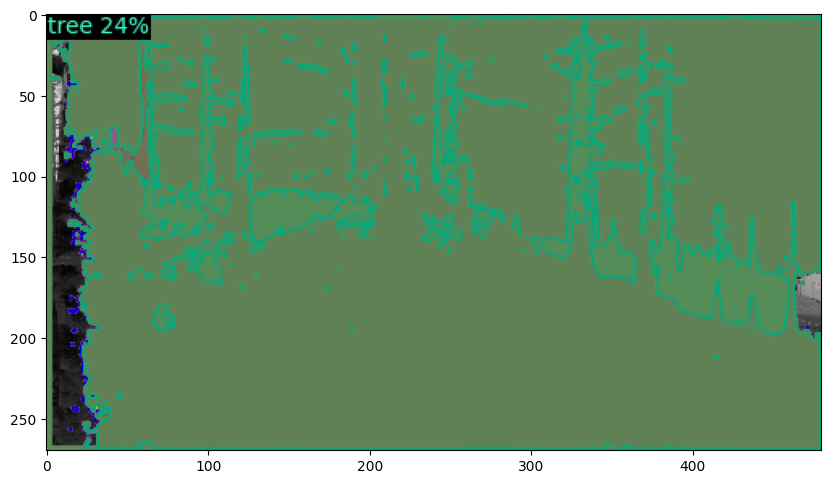

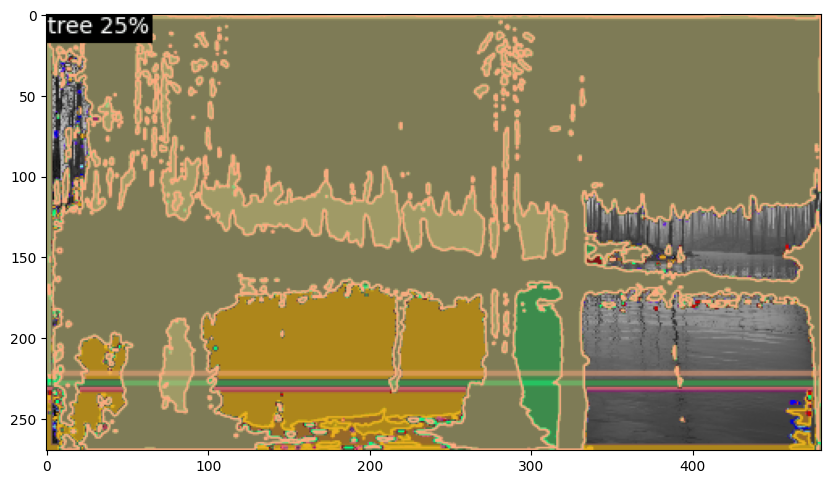

In [45]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(valid_dataset_dicts, 2):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=valid_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])